In [ ]:
!pip install SoundFile transformers scikit-learn gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.6 MB/s eta 0:00:00


In [ ]:

import gradio as gr
import torch
import soundfile as sf
import os
import numpy as np

import os
import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
from collections import Counter

device = torch.device("cpu")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=2).to(device)
# model_path = "dysarthria_classifier12.pth"
# model_path = '/home/user/app/dysarthria_classifier12.pth'

model_path = "/content/dysarthria_classifier12.pth"
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# if os.path.exists(model_path):
#     print(f"Loading saved model {model_path}")
#     model.load_state_dict(torch.load(model_path))
def predict(file_path):
    max_length = 100000

    model.eval()
    with torch.no_grad():
        wav_data, _ = sf.read(file_path.name)
        inputs = processor(wav_data, sampling_rate=16000, return_tensors="pt", padding=True)

        input_values = inputs.input_values.squeeze(0)
        if max_length - input_values.shape[-1] > 0:
            input_values = torch.cat([input_values, torch.zeros((max_length - input_values.shape[-1],))], dim=-1)
        else:
            input_values = input_values[:max_length]
        input_values = input_values.unsqueeze(0).to(device)
        inputs = {"input_values": input_values}

        logits = model(**inputs).logits
        logits = logits.squeeze()
        predicted_class_id = torch.argmax(logits, dim=-1).item()

    return predicted_class_id

iface = gr.Interface(fn=predict, inputs="file", outputs="text")
iface.launch()


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForSequenceClassification: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'projector.bias', 'classifier.weight', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be 

RuntimeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import os
import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
from sklearn.model_selection import train_test_split
import re
from collections import Counter
from sklearn.metrics import classification_report


In [ ]:

# Custom Dataset class
class DysarthriaDataset(Dataset):
    def __init__(self, data, labels, max_length=100000):
        self.data = data
        self.labels = labels
        self.max_length = max_length
        self.processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
          wav_data, _ = sf.read(self.data[idx])
        except:
          print(f"Error opening file: {self.data[idx]}. Skipping...")
          return self.__getitem__((idx + 1) % len(self.data))
        inputs = self.processor(wav_data, sampling_rate=16000, return_tensors="pt", padding=True)
        input_values = inputs.input_values.squeeze(0)  # Squeeze the batch dimension
        if self.max_length - input_values.shape[-1] > 0:
            input_values = torch.cat([input_values, torch.zeros((self.max_length - input_values.shape[-1],))], dim=-1)
        else:
            input_values = input_values[:self.max_length]

        # Remove unsqueezing the channel dimension
        # input_values = input_values.unsqueeze(0)

        # label = torch.zeros(32,dtype=torch.long)
        # label[self.labels[idx]] = 1

        ### CHANGES: simply return the label as a single integer
        return {"input_values": input_values}, self.labels[idx]
        # return {"input_values": input_values, "audio_path": self.data[idx]}, self.labels[idx]
        ###


In [ ]:
def train(model, dataloader, criterion, optimizer, device, loss_vals, epochs, current_epoch):
    model.train()
    running_loss = 0

    for i, (inputs, labels) in enumerate(dataloader):
        inputs = {key: value.squeeze().to(device) for key, value in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(**inputs).logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        # append loss value to list
        loss_vals.append(loss.item())
        running_loss += loss.item()

        if i % 10 == 0:  # Update the plot every 10 iterations
            plt.clf()  # Clear the previous plot
            plt.plot(loss_vals)
            plt.xlim([0, len(dataloader)*epochs])
            plt.ylim([0, max(loss_vals) + 2])
            plt.xlabel('Training Iterations')
            plt.ylabel('Loss')
            plt.title(f"Training Loss at Epoch {current_epoch + 1}")
            plt.pause(0.001)  # Pause to update the plot

    avg_loss = running_loss / len(dataloader)
    print(f"Average Loss after Epoch {current_epoch + 1}: {avg_loss}\n")
    return avg_loss

In [ ]:

def predict(model, file_path, processor, device, max_length=100000): ### CHANGES: added max_length as an argument.
    model.eval()
    with torch.no_grad():
        wav_data, _ = sf.read(file_path)
        inputs = processor(wav_data, sampling_rate=16000, return_tensors="pt", padding=True)
        # inputs = {key: value.squeeze().to(device) for key, value in inputs.items()}

        ### NEW CODES HERE
        input_values = inputs.input_values.squeeze(0)  # Squeeze the batch dimension
        if max_length - input_values.shape[-1] > 0:
            input_values = torch.cat([input_values, torch.zeros((max_length - input_values.shape[-1],))], dim=-1)
        else:
            input_values = input_values[:max_length]
        input_values = input_values.unsqueeze(0).to(device)
        inputs = {"input_values": input_values}
        ###

        logits = model(**inputs).logits
        # _, predicted = torch.max(logits, dim=0)

        ### NEW CODES HERE
        # Remove the batch dimension.
        logits = logits.squeeze()
        predicted_class_id = torch.argmax(logits, dim=-1).item()
        ###

    # return predicted.item()
    return predicted_class_id


In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0
    correct_predictions = 0
    total_predictions = 0
    wrong_files = []
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = {key: value.squeeze().to(device) for key, value in inputs.items()}
            labels = labels.to(device)

            logits = model(**inputs).logits
            loss = criterion(logits, labels)
            running_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            wrong_idx = (predicted != labels).nonzero().squeeze().cpu().numpy()
            if wrong_idx.ndim > 0:
                for idx in wrong_idx:
                    wrong_files.append(dataloader.dataset.data[idx])
            elif wrong_idx.size > 0:
                wrong_files.append(dataloader.dataset.data[wrong_idx])

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_loss = running_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions

    return avg_loss, accuracy, wrong_files, np.array(all_labels), np.array(all_predictions)


In [ ]:
def get_wav_files(base_path):
    wav_files = []
    for subject_folder in os.listdir(base_path):
        subject_path = os.path.join(base_path, subject_folder)
        if os.path.isdir(subject_path):
            for wav_file in os.listdir(subject_path):
                if wav_file.endswith('.wav'):
                    wav_files.append(os.path.join(subject_path, wav_file))

    return wav_files

In [ ]:
def get_torgo_data(dysarthria_path, non_dysarthria_path):
    dysarthria_files = [os.path.join(dysarthria_path, f) for f in os.listdir(dysarthria_path) if f.endswith('.wav')]
    non_dysarthria_files = [os.path.join(non_dysarthria_path, f) for f in os.listdir(non_dysarthria_path) if f.endswith('.wav')]

    data = dysarthria_files + non_dysarthria_files
    labels = [1] * len(dysarthria_files) + [0] * len(non_dysarthria_files)

    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, stratify=labels)
    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, stratify=train_labels) # 0.25 x 0.8 = 0.2

    return train_data, val_data, test_data, train_labels, val_labels, test_labels

In [ ]:

    dysarthria_path = "/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS"
    non_dysarthria_path = "/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS"

    dysarthria_files = get_wav_files(dysarthria_path)
    non_dysarthria_files = get_wav_files(non_dysarthria_path)



    data = dysarthria_files + non_dysarthria_files
    labels = [1] * len(dysarthria_files) + [0] * len(non_dysarthria_files)

    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, stratify=labels)
    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, stratify=train_labels) # 0.25 x 0.8 = 0.2
    train_dataset = DysarthriaDataset(train_data, train_labels)
    test_dataset = DysarthriaDataset(test_data, test_labels)
    val_dataset = DysarthriaDataset(val_data, val_labels) # Create a validation dataset

    train_loader = DataLoader(train_dataset, batch_size=16, drop_last=False)
    test_loader = DataLoader(test_dataset, batch_size=16, drop_last=False)
    validation_loader = DataLoader(val_dataset, batch_size=16, drop_last=False) # Use the validation dataset for the validation_loader

    """ dysarthria_path = "/content/drive/MyDrive/torgo_data/dysarthria_male/training"
    non_dysarthria_path = "/content/drive/MyDrive/torgo_data/non_dysarthria_male/training"

    dysarthria_files = [os.path.join(dysarthria_path, f) for f in os.listdir(dysarthria_path) if f.endswith('.wav')]
    non_dysarthria_files = [os.path.join(non_dysarthria_path, f) for f in os.listdir(non_dysarthria_path) if f.endswith('.wav')]

    data = dysarthria_files + non_dysarthria_files
    labels = [1] * len(dysarthria_files) + [0] * len(non_dysarthria_files)

    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

    train_dataset = DysarthriaDataset(train_data, train_labels)
    test_dataset = DysarthriaDataset(test_data, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=8, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=8, drop_last=True)
    validation_loader = DataLoader(test_dataset, batch_size=8, drop_last=True)

    dysarthria_validation_path = "/content/drive/MyDrive/torgo_data/dysarthria_male/validation"
    non_dysarthria_validation_path = "/content/drive/MyDrive/torgo_data/non_dysarthria_male/validation"

    dysarthria_validation_files = [os.path.join(dysarthria_validation_path, f) for f in os.listdir(dysarthria_validation_path) if f.endswith('.wav')]
    non_dysarthria_validation_files = [os.path.join(non_dysarthria_validation_path, f) for f in os.listdir(non_dysarthria_validation_path) if f.endswith('.wav')]

    validation_data = dysarthria_validation_files + non_dysarthria_validation_files
    validation_labels = [1] * len(dysarthria_validation_files) + [0] * len(non_dysarthria_validation_files)"""




    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")












    # model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(device)
    # model.classifier = nn.Linear(model.config.hidden_size, 2).to(device)

    ### NEW CODES
    # It seems like the classifier layer is excluded from the model's forward method (i.e., model(**inputs)).
    # That's why the number of labels in the output was 32 instead of 2 even when you had already changed the classifier.
    # Instead, huggingface offers the option for loading the Wav2Vec model with an adjustable classifier head on top (by setting num_labels).

    model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=2).to(device)
    ##
    model_path = "/content/dysarthria_classifier1.pth"
    if os.path.exists(model_path):
        print(f"Loading saved model {model_path}")
        model.load_state_dict(torch.load(model_path))

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForSequenceClassification: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['projector.weight', 'classifier.bias', 'wav2vec2.masked_spec_embed', 'classifier.weight', 'projector.bias']
You should probably TRAIN this model on a down-stream task to be 

In [ ]:
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

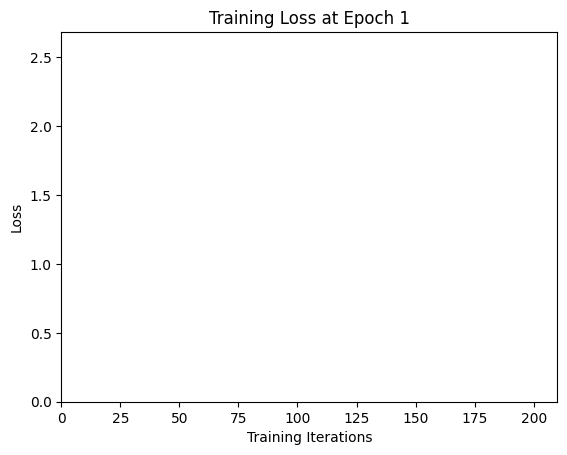

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


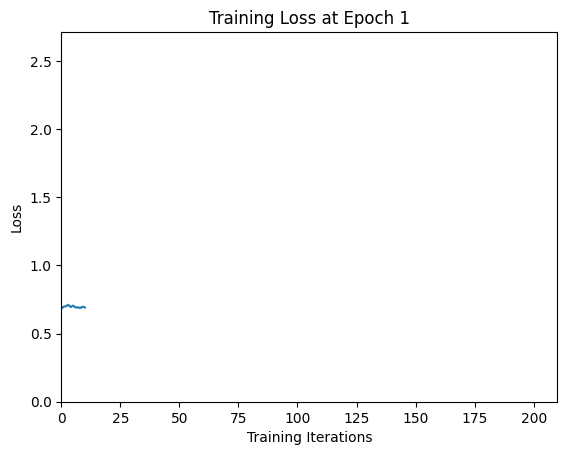

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


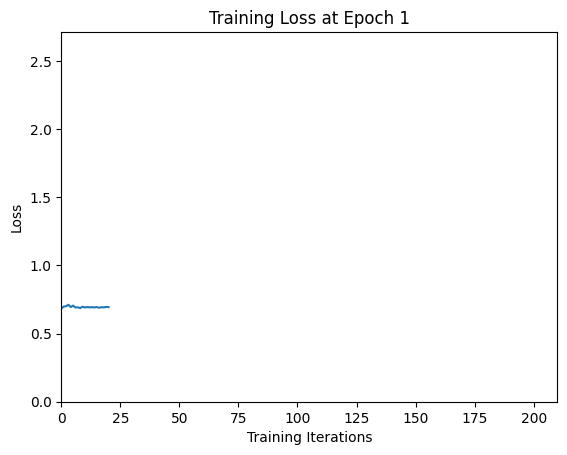

Average Loss after Epoch 1: 0.694305868375869

Epoch 1, Train Loss: 0.694305868375869
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 1, Validation Loss: 0.6939887830189296, Validation Accuracy: 0.46
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP022_ANALYSIS/SP022_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP019_ANALYSIS/SP019_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT025_ANALYSIS/CT025_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALY

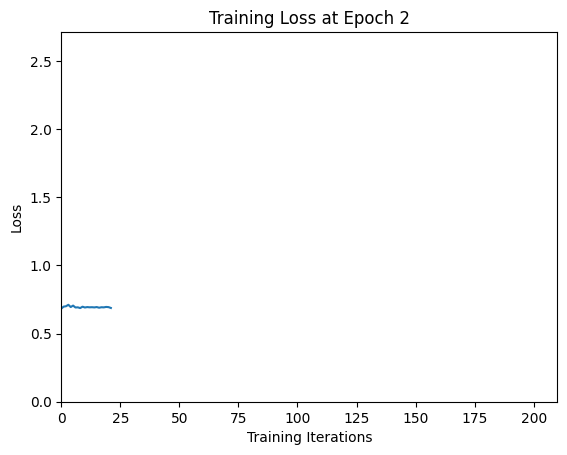

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


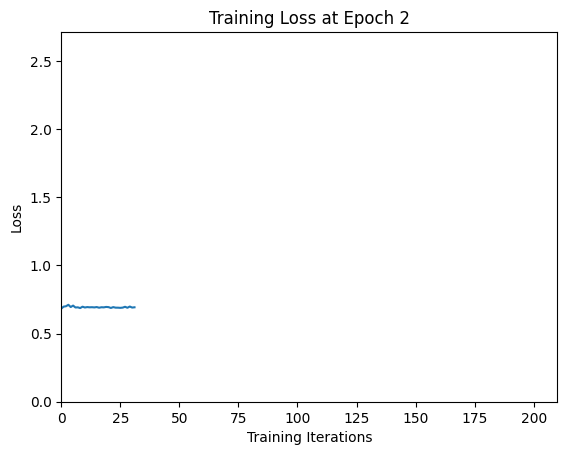

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


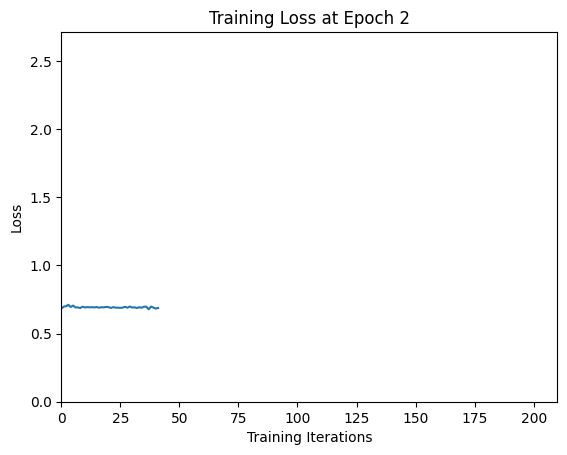

Average Loss after Epoch 2: 0.6908744601976304

Epoch 2, Train Loss: 0.6908744601976304
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 2, Validation Loss: 0.6937627111162458, Validation Accuracy: 0.50
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT025_ANALYSIS/CT025_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT011_ANALYSIS/CT011_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT027_ANALYSIS/CT027_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANA

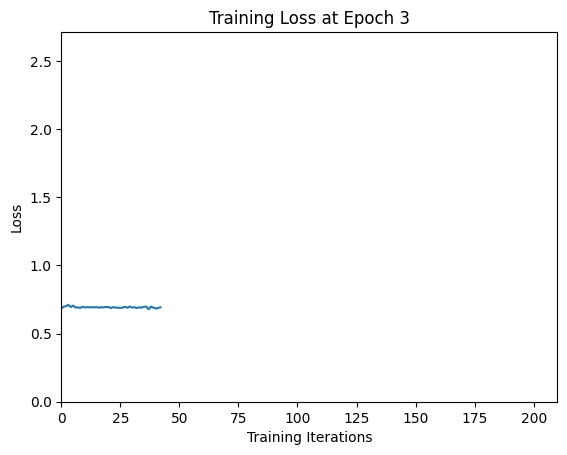

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


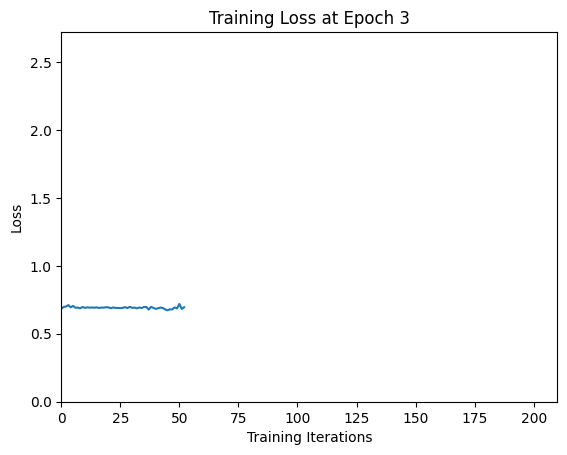

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


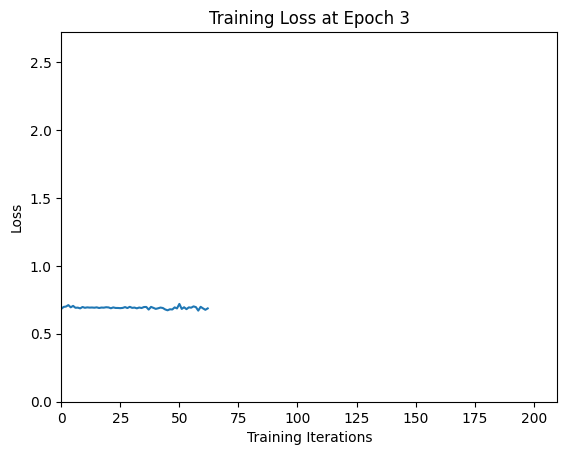

Average Loss after Epoch 3: 0.6883202649298168

Epoch 3, Train Loss: 0.6883202649298168
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 3, Validation Loss: 0.6907691104071481, Validation Accuracy: 0.54
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP022_ANALYSIS/SP022_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT025_ANALYSIS/CT025_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT011_ANALYSIS/CT011_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT027_ANALYSIS/CT027_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANA

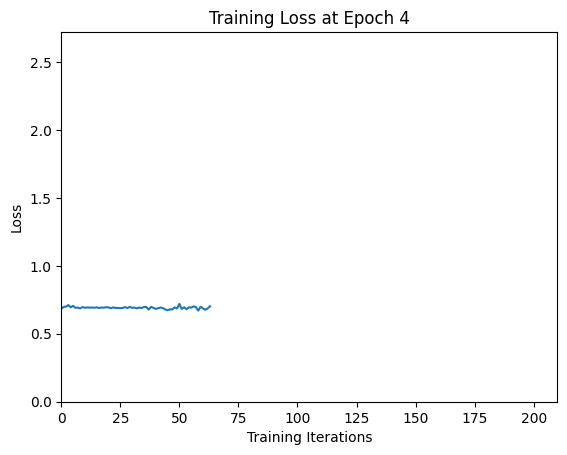

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


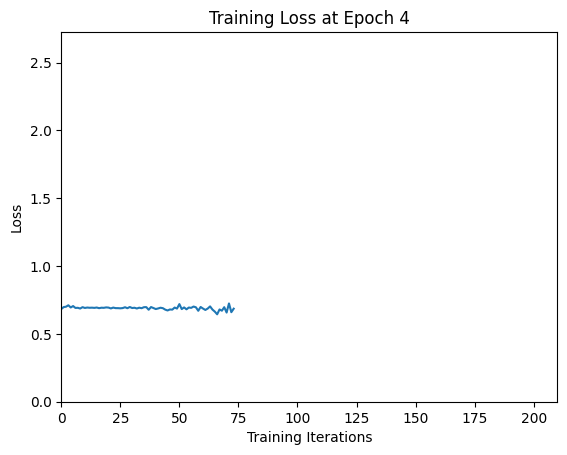

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


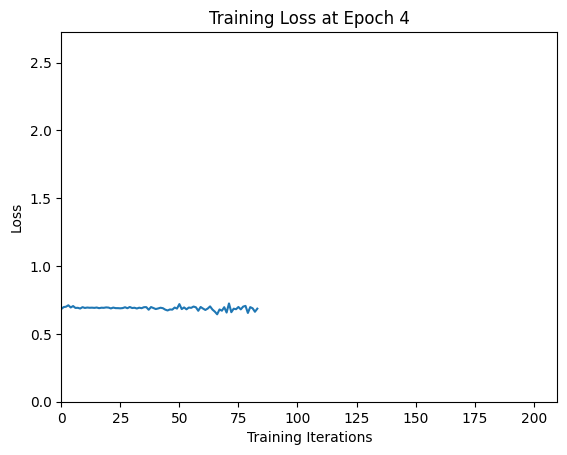

Average Loss after Epoch 4: 0.682107633068448

Epoch 4, Train Loss: 0.682107633068448
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 4, Validation Loss: 0.6902644804545811, Validation Accuracy: 0.51
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT025_ANALYSIS/CT025_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT011_ANALYSIS/CT011_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT027_ANALYSIS/CT027_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALY

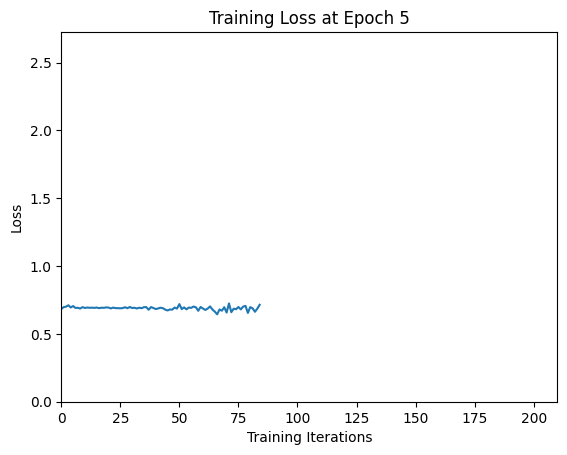

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


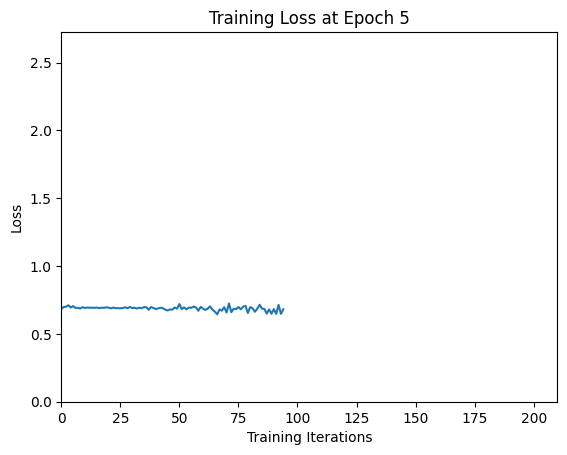

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


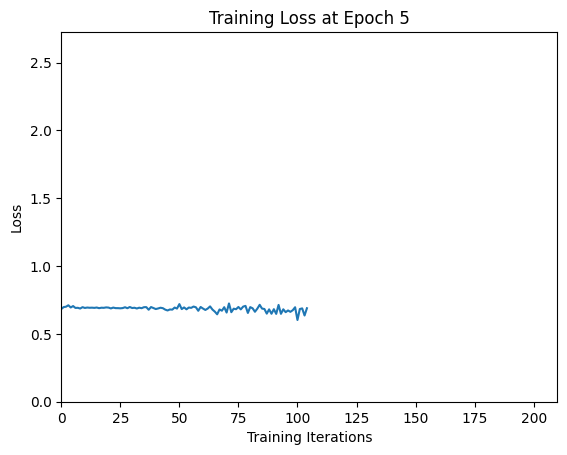

Average Loss after Epoch 5: 0.6714223424593607

Epoch 5, Train Loss: 0.6714223424593607
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 5, Validation Loss: 0.6882192151887077, Validation Accuracy: 0.49
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT025_ANALYSIS/CT025_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT011_ANALYSIS/CT011_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP001_ANALYSIS/SP001_5.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANA

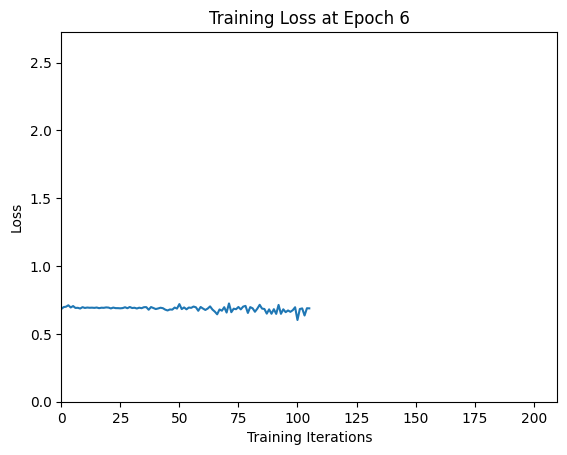

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


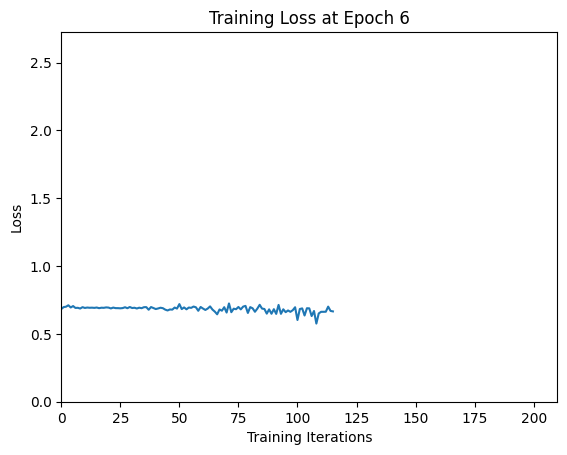

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


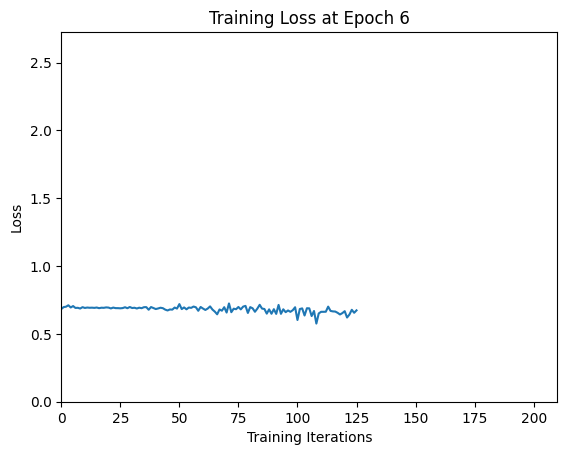

Average Loss after Epoch 6: 0.6568549615996224

Epoch 6, Train Loss: 0.6568549615996224
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 6, Validation Loss: 0.6880387238093785, Validation Accuracy: 0.50
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT025_ANALYSIS/CT025_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT011_ANALYSIS/CT011_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP001_ANALYSIS/SP001_5.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANA

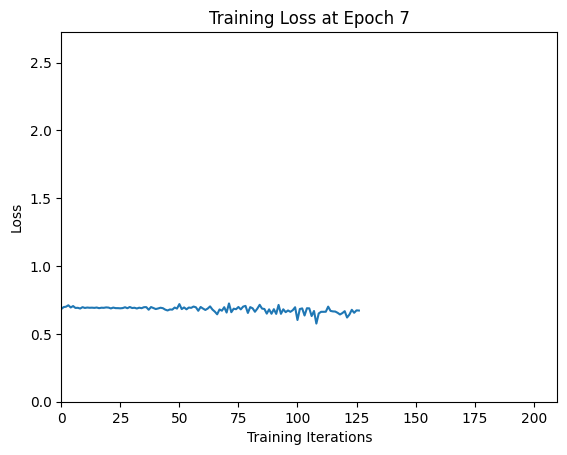

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


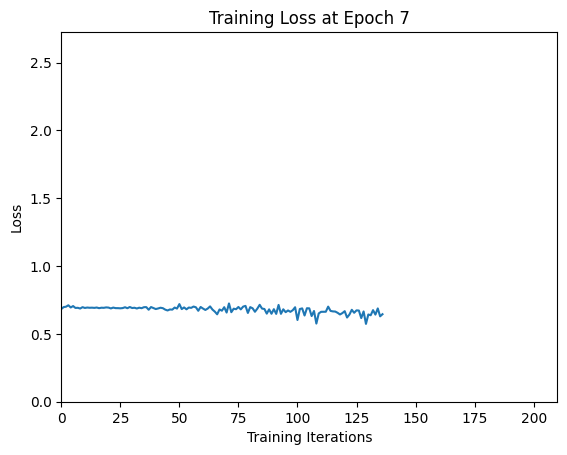

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


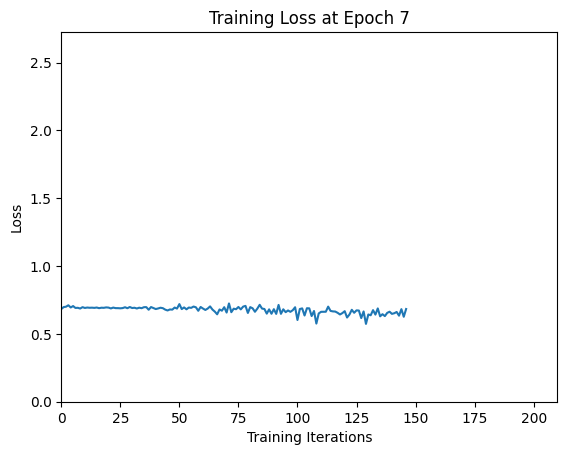

Average Loss after Epoch 7: 0.6488193216777983

Epoch 7, Train Loss: 0.6488193216777983
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 7, Validation Loss: 0.6846180813653129, Validation Accuracy: 0.51
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT025_ANALYSIS/CT025_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT011_ANALYSIS/CT011_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP001_ANALYSIS/SP001_5.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANA

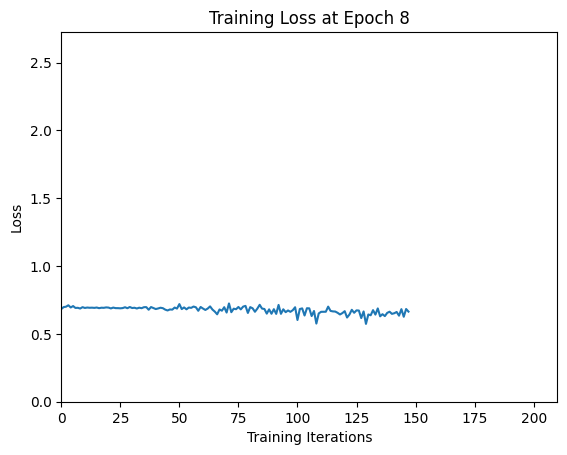

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


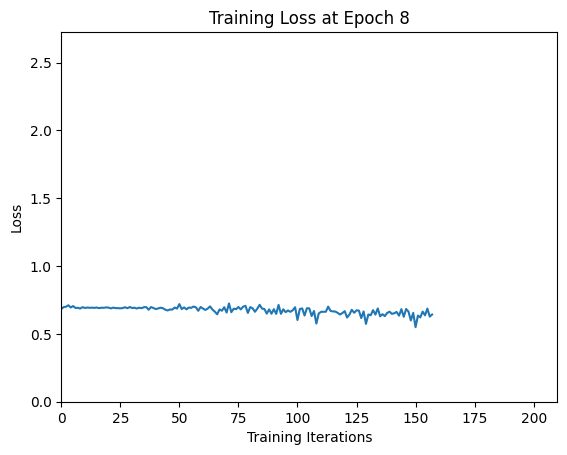

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


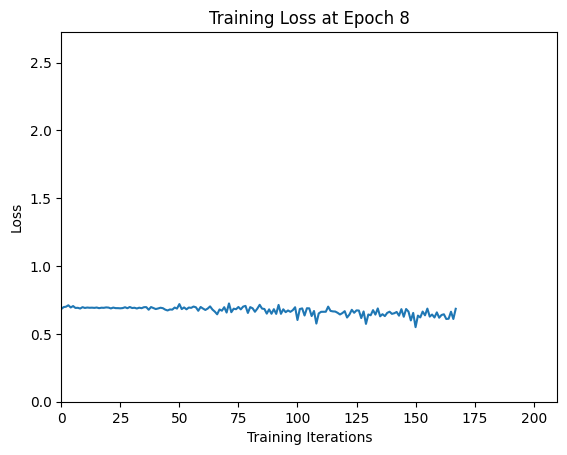

Average Loss after Epoch 8: 0.6354747868719555

Epoch 8, Train Loss: 0.6354747868719555
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 8, Validation Loss: 0.6784673673766, Validation Accuracy: 0.51
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT025_ANALYSIS/CT025_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT011_ANALYSIS/CT011_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP001_ANALYSIS/SP001_5.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYS

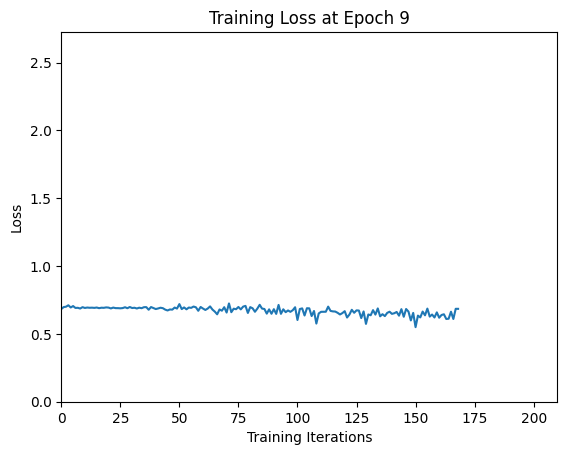

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


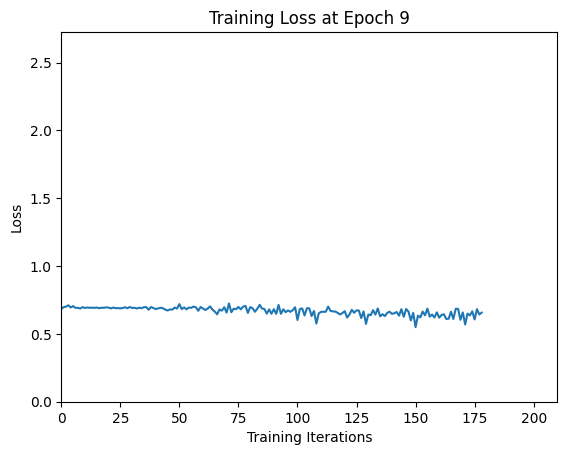

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


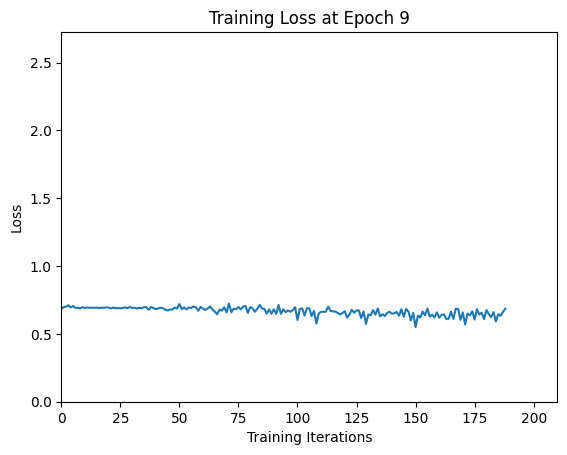

Average Loss after Epoch 9: 0.6423204228991554

Epoch 9, Train Loss: 0.6423204228991554
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 9, Validation Loss: 0.6726547053882054, Validation Accuracy: 0.52
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT025_ANALYSIS/CT025_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT011_ANALYSIS/CT011_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP001_ANALYSIS/SP001_5.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANA

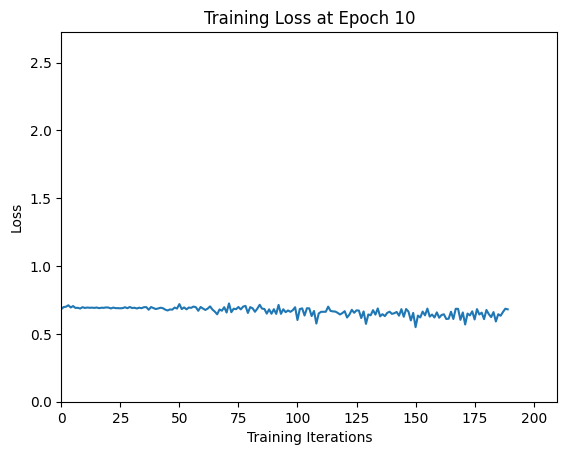

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


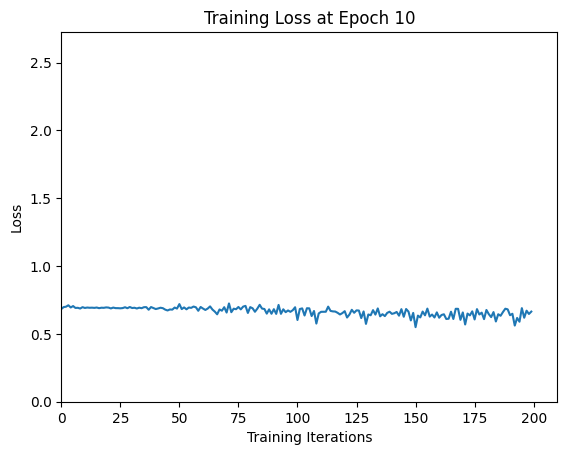

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


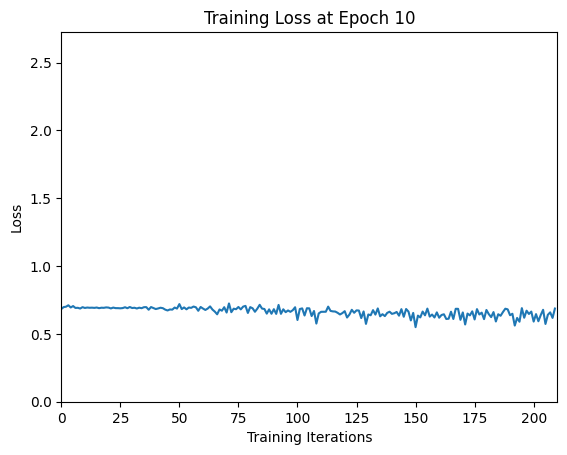

Average Loss after Epoch 10: 0.6357171194893974

Epoch 10, Train Loss: 0.6357171194893974
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 10, Validation Loss: 0.6663738063403538, Validation Accuracy: 0.54
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP022_ANALYSIS/SP022_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT025_ANALYSIS/CT025_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT011_ANALYSIS/CT011_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_

In [ ]:


   # dysarthria_validation_path = "/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/testing"
   # non_dysarthria_validation_path = "/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/testing"

    #dysarthria_validation_files = get_wav_files(dysarthria_validation_path)
   # non_dysarthria_validation_files = get_wav_files(non_dysarthria_validation_path)

    #validation_data = dysarthria_validation_files + non_dysarthria_validation_files
    #validation_labels = [1] * len(dysarthria_validation_files) + [0] * len(non_dysarthria_validation_files)

epochs = 10
plt.ion()
fig, ax = plt.subplots()
x_vals = np.arange(len(train_loader)*epochs)
loss_vals = []
for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device, loss_vals, epochs, epoch)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss}")

    val_loss, val_accuracy, wrong_files, true_labels, pred_labels = evaluate(model, validation_loader, criterion, device)
    print(f"Epoch {epoch + 1}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy:.2f}")
    print("Misclassified Files")
    for file_path in wrong_files:
      print(file_path)


    sentence_pattern = re.compile(r"_(\d+)\.wav$")

    sentence_counts = Counter()
    for file_path in wrong_files:
        match = sentence_pattern.search(file_path)
        if match:
            sentence_number = int(match.group(1))
            sentence_counts[sentence_number] += 1

    total_wrong = len(wrong_files)
    print("Total wrong files:", total_wrong)
    print()

    for sentence_number, count in sentence_counts.most_common():
        percent = count / total_wrong * 100
        print(f"Sentence {sentence_number}: {count} ({percent:.2f}%)")
    scheduler.step()
    print(classification_report(true_labels, pred_labels, target_names=['non_dysarthria', 'dysarthria']))
audio_file = "/content/drive/MyDrive/torgo_data/dysarthria_male/validation/M01_Session1_0005.wav"
predicted_label = predict(model, audio_file, train_dataset.processor, device)
print(f"Predicted label: {predicted_label}")





# Test on a specific audio file
##audio_file = "/content/drive/MyDrive/torgo_data/dysarthria_male/validation/M01_Session1_0005.wav"
##predicted_label = predict(model, audio_file, train_dataset.processor, device)
##print(f"Predicted label: {predicted_label}")


In [ ]:
torch.save(model.state_dict(), "dysarthria_classifier1.pth")
print("Predicting...")

Predicting...


#audio aug

In [ ]:
!pip install audiomentations
from audiomentations import Compose, PitchShift, TimeStretch

augmenter = Compose([
    PitchShift(min_semitones=-2, max_semitones=2, p=0.1),
    TimeStretch(min_rate=0.9, max_rate=1.1, p=0.1)
])


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 14.1 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.0.post2
    Uninstalling librosa-0.10.0.post2:
      Successfully uninstalled librosa-0.10.0.post2


In [ ]:
# from torch.optim.lr_scheduler import StepLR

# scheduler = StepLR(optimizer, step_size=2, gamma=0.5)

from transformers import get_linear_schedule_with_warmup

# Define the total number of training steps
# It is usually the number of epochs times the number of batches per epoch
num_training_steps = epochs * len(train_loader)

# Define the number of warmup steps
# Usually set to a fraction of total_training_steps such as 0.1 * num_training_steps
num_warmup_steps = int(num_training_steps * 0.3)

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)


In [ ]:
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=2).to(device)
    ##
model_path = "/content/models/my_model_06/pytorch_model.bin"
if os.path.exists(model_path):
    print(f"Loading saved model {model_path}")
    model.load_state_dict(torch.load(model_path))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForSequenceClassification: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['projector.weight', 'classifier.bias', 'wav2vec2.masked_spec_embed', 'classifier.weight', 'projector.bias']
You should probably TRAIN this model on a down-stream task to be 

In [ ]:
import numpy as np

def trainaug(model, dataloader, criterion, optimizer, device, loss_vals, epochs, current_epoch):
    model.train()
    running_loss = 0

    for i, (inputs, labels) in enumerate(dataloader):
        inputs = {key: value.squeeze().to(device) for key, value in inputs.items() if torch.is_tensor(value)}
        labels = labels.to(device)

        # Apply audio augmentation
        augmented_audio = []
        for audio in inputs['input_values']:
            # The augmenter works with numpy arrays, so we need to convert the tensor to a numpy array
            audio_np = audio.cpu().numpy()

            # Apply the augmentation
            augmented = augmenter(audio_np, sample_rate=16000)  # Assuming a sample rate of 16000Hz

            augmented_audio.append(augmented)

        # Convert the list of numpy arrays back to a tensor
        inputs['input_values'] = torch.from_numpy(np.array(augmented_audio)).to(device)

        optimizer.zero_grad()
        logits = model(**inputs).logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        # append loss value to list
        loss_vals.append(loss.item())
        running_loss += loss.item()

        if i % 10 == 0:  # Update the plot every 10 iterations
            plt.clf()  # Clear the previous plot
            plt.plot(loss_vals)
            plt.xlim([0, len(dataloader)*epochs])
            plt.ylim([0, max(loss_vals) + 2])
            plt.xlabel('Training Iterations')
            plt.ylabel('Loss')
            plt.title(f"Training Loss at Epoch {current_epoch + 1}")
            plt.pause(0.001)  # Pause to update the plot

    avg_loss = running_loss / len(dataloader)
    print(f"Average Loss after Epoch {current_epoch + 1}: {avg_loss}\n")
    return avg_loss


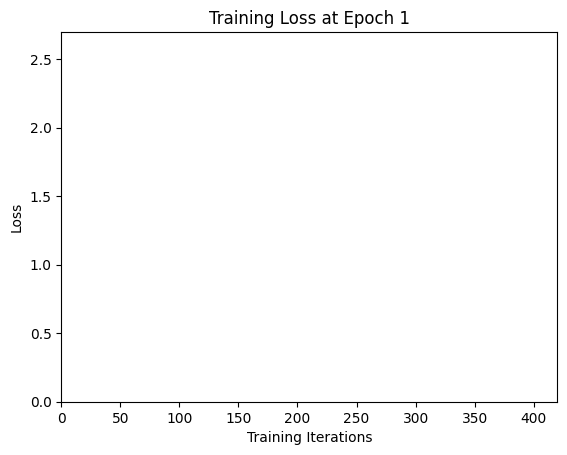

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


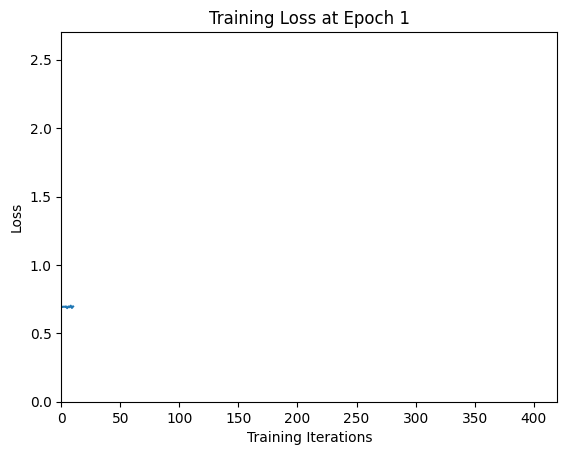

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


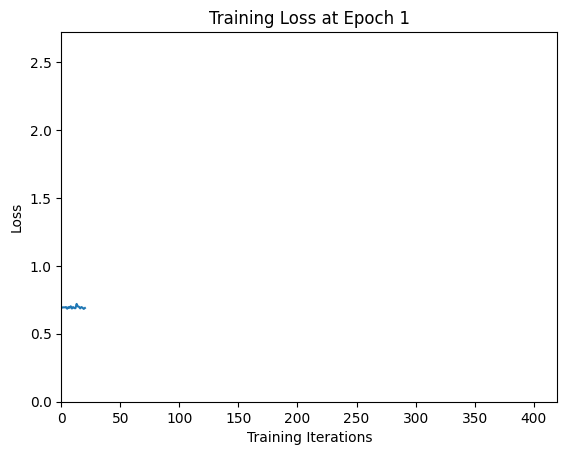

Average Loss after Epoch 1: 0.6940996845563253

Epoch 1, Train Loss: 0.6940996845563253
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 1, Validation Loss: 0.6921902469226292, Validation Accuracy: 0.51
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT025_ANALYSIS/CT025_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT011_ANALYSIS/CT011_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT027_ANALYSIS/CT027_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP019_ANALYSIS/SP019_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANA

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defin

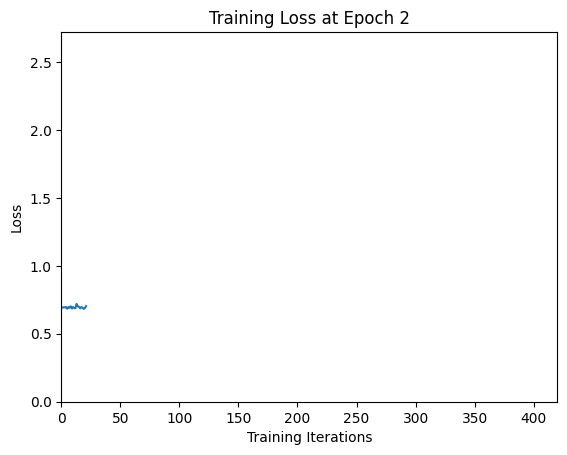

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


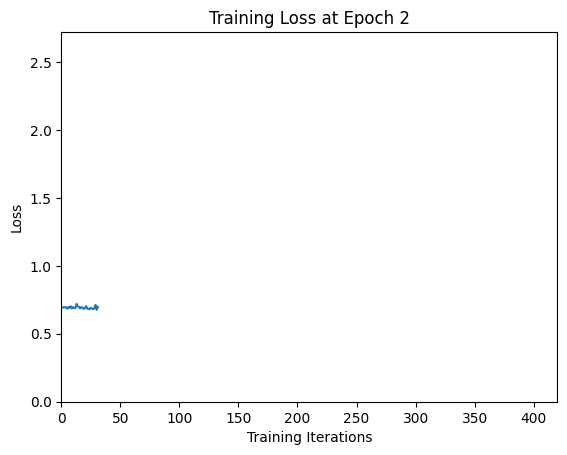

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


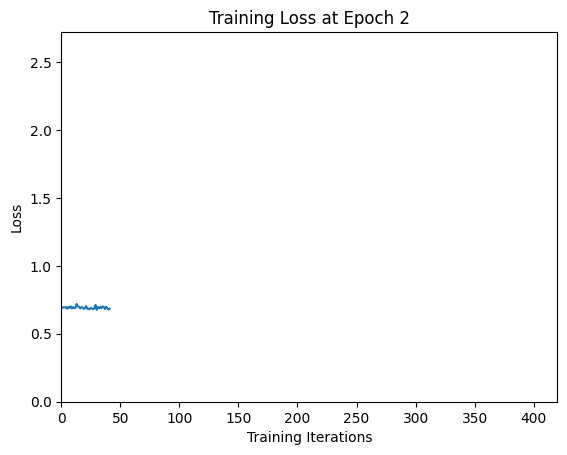

Average Loss after Epoch 2: 0.6898957945051647

Epoch 2, Train Loss: 0.6898957945051647
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 2, Validation Loss: 0.6928852541106088, Validation Accuracy: 0.50
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT025_ANALYSIS/CT025_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT011_ANALYSIS/CT011_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT027_ANALYSIS/CT027_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP019_ANALYSIS/SP019_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANA

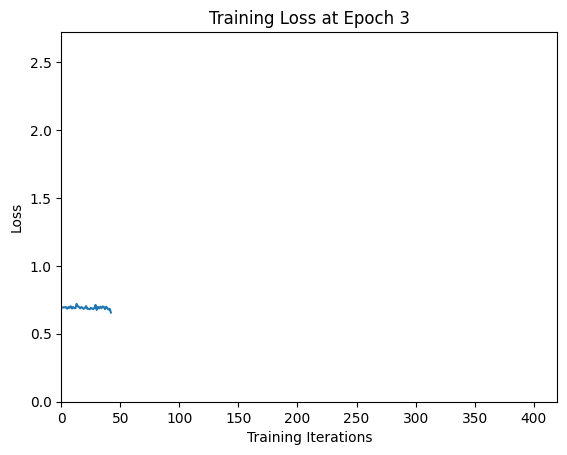

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


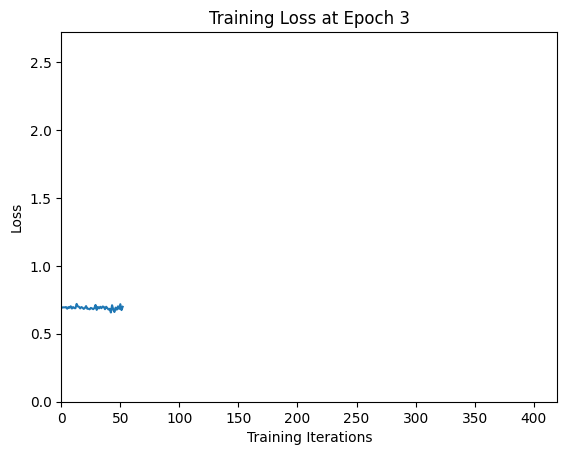

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


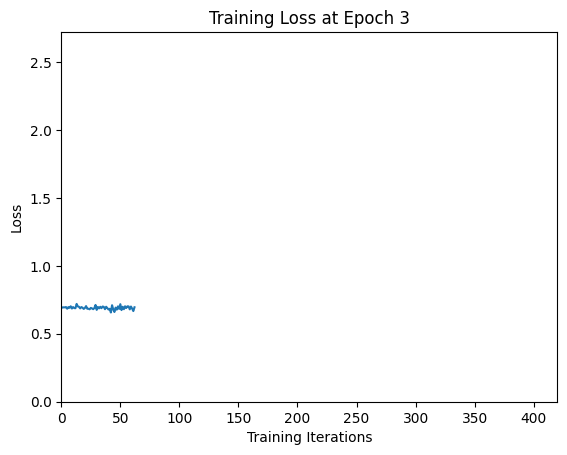

Average Loss after Epoch 3: 0.6883602284249806

Epoch 3, Train Loss: 0.6883602284249806
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 3, Validation Loss: 0.6904000129018512, Validation Accuracy: 0.51
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT025_ANALYSIS/CT025_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT011_ANALYSIS/CT011_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT027_ANALYSIS/CT027_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP019_ANALYSIS/SP019_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANA

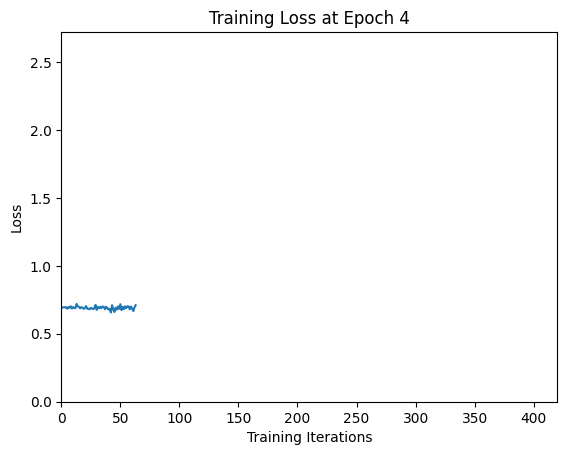

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


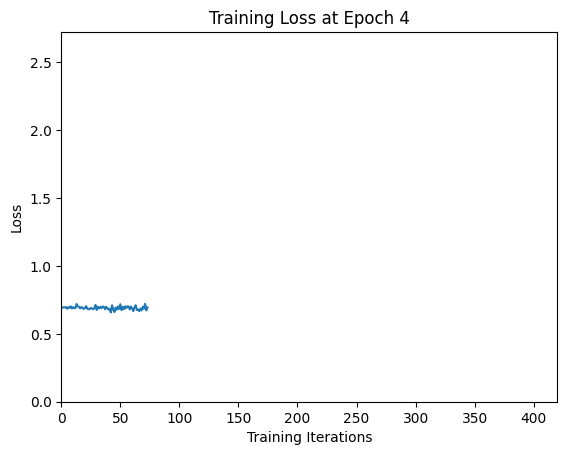

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


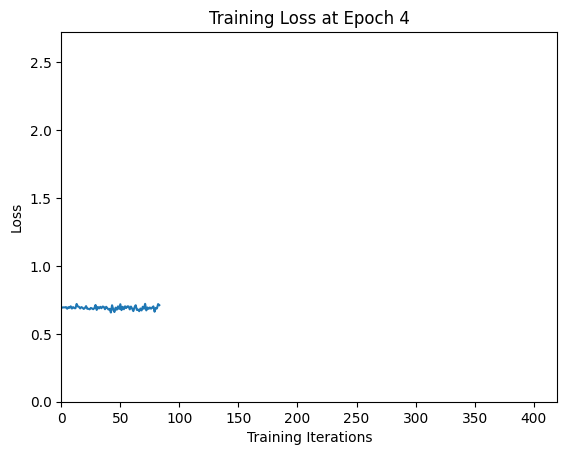

Average Loss after Epoch 4: 0.6897572875022888

Epoch 4, Train Loss: 0.6897572875022888
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 4, Validation Loss: 0.7018356323242188, Validation Accuracy: 0.49
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT025_ANALYSIS/CT025_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP001_ANALYSIS/SP001_5.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANA

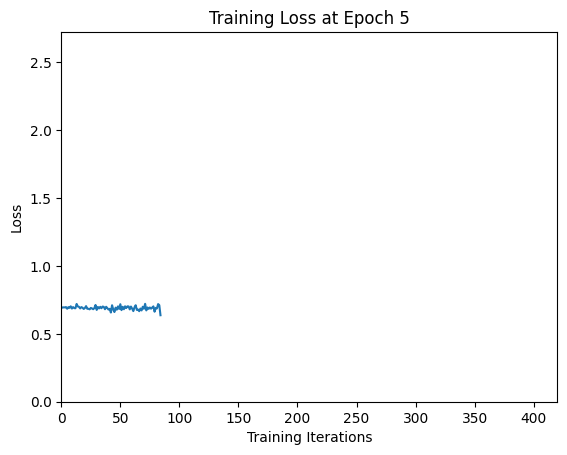

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


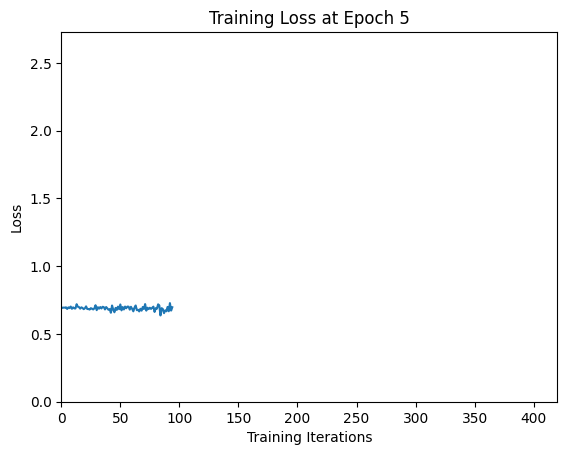

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


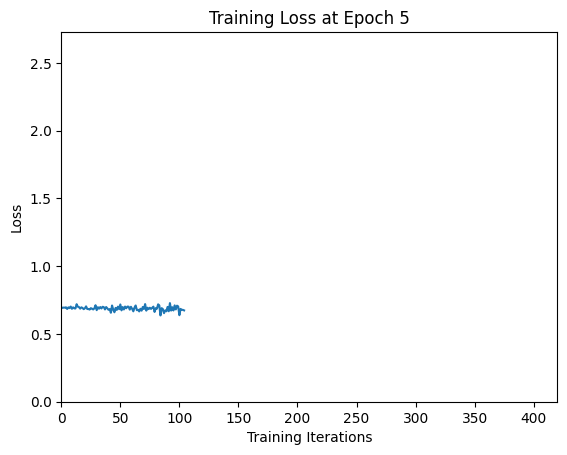

Average Loss after Epoch 5: 0.6810367079008193

Epoch 5, Train Loss: 0.6810367079008193
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 5, Validation Loss: 0.6822995032582965, Validation Accuracy: 0.53
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT025_ANALYSIS/CT025_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP001_ANALYSIS/SP001_5.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT027_ANALYSIS/CT027_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANA

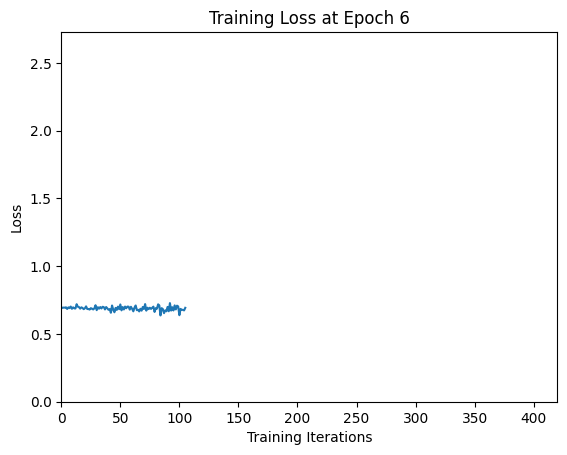

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


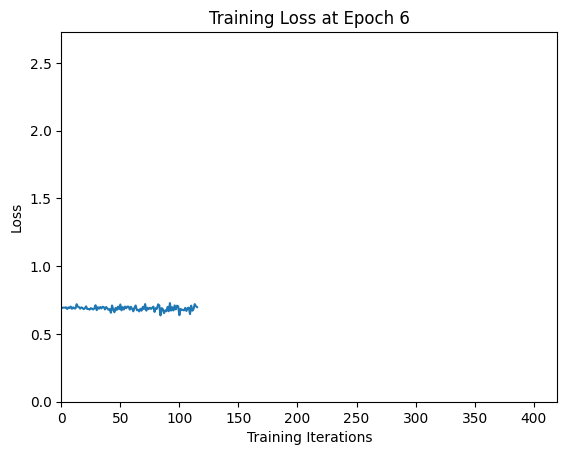

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


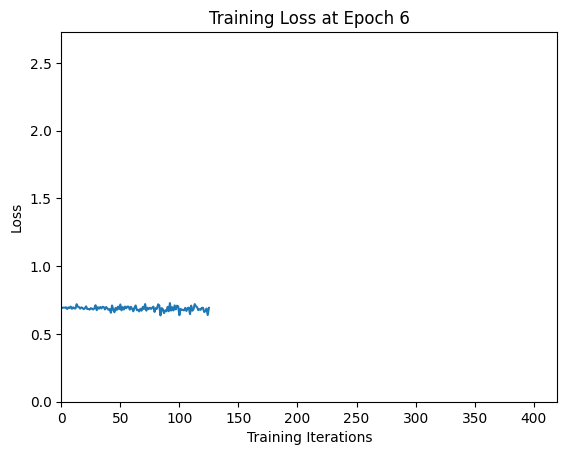

Average Loss after Epoch 6: 0.6835410453024364

Epoch 6, Train Loss: 0.6835410453024364
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 6, Validation Loss: 0.6706692235810416, Validation Accuracy: 0.55
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT025_ANALYSIS/CT025_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT011_ANALYSIS/CT011_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP001_ANALYSIS/SP001_5.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANA

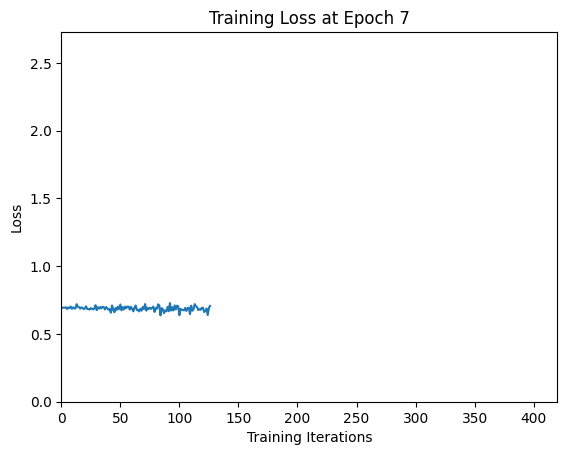

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


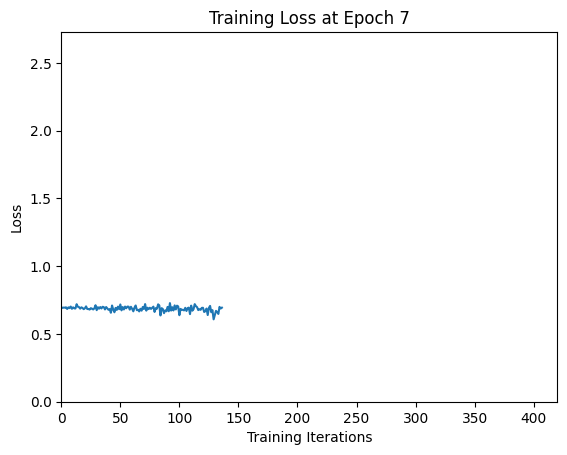

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


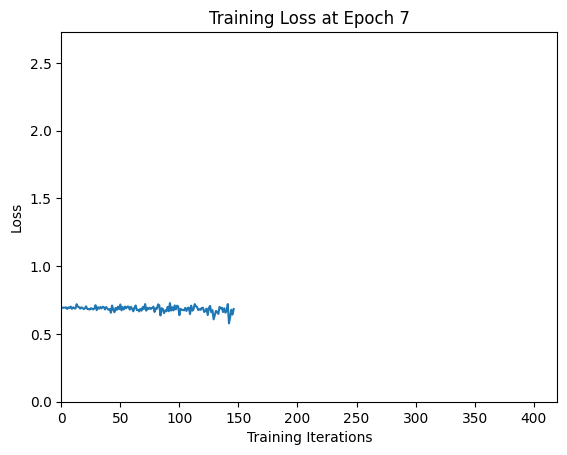

Average Loss after Epoch 7: 0.6649685473669142

Epoch 7, Train Loss: 0.6649685473669142
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 7, Validation Loss: 0.6676671249525887, Validation Accuracy: 0.58
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP026_ANALYSIS/SP026_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP001_ANALYSIS/SP001_5.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP022_ANALYSIS/SP022_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP035_ANALYSIS/SP035_8.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANA

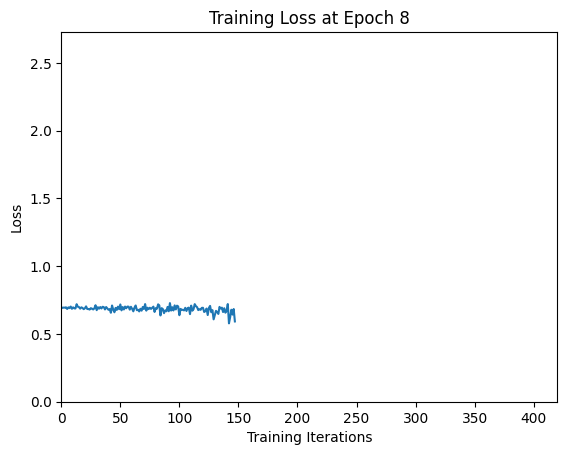

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


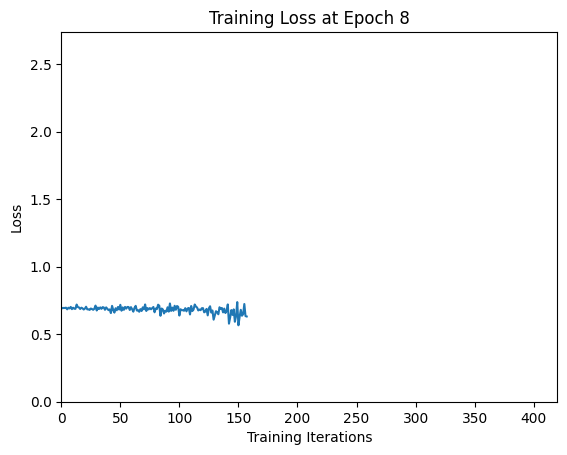

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


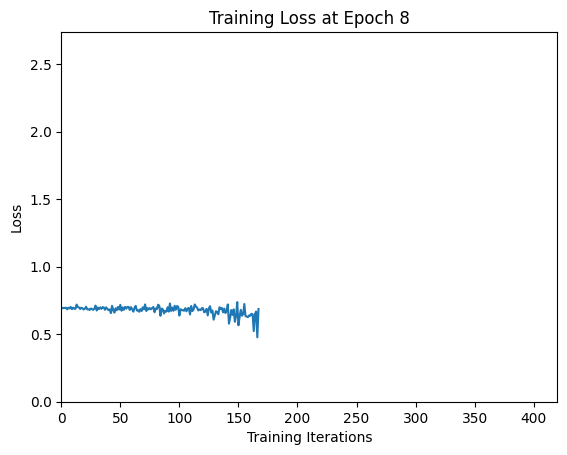

Average Loss after Epoch 8: 0.6342739306745075

Epoch 8, Train Loss: 0.6342739306745075
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 8, Validation Loss: 0.6931556292942592, Validation Accuracy: 0.57
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP026_ANALYSIS/SP026_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP001_ANALYSIS/SP001_5.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP022_ANALYSIS/SP022_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT025_ANALYSIS/CT025_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP035_ANALYSIS/SP035_8.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANA

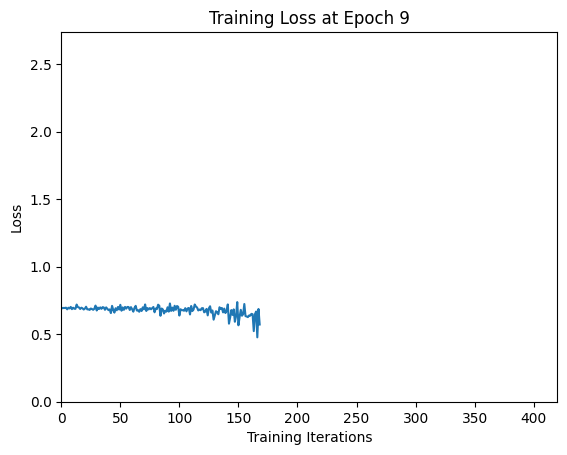

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


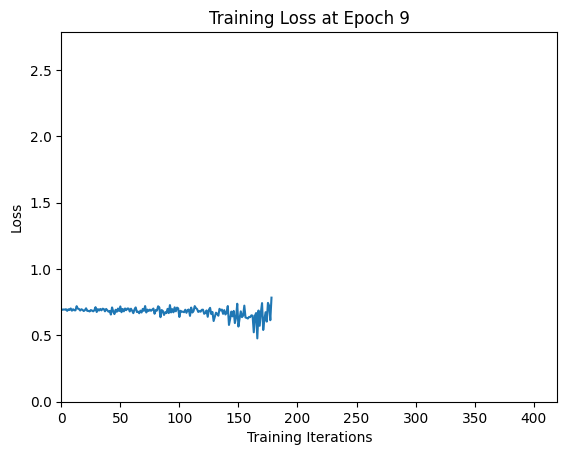

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


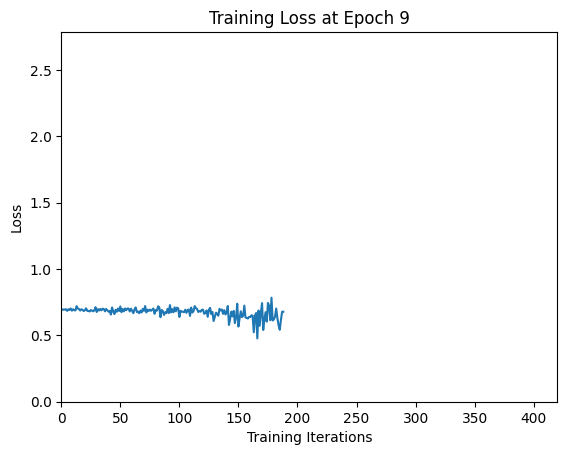

Average Loss after Epoch 9: 0.6467996409961155

Epoch 9, Train Loss: 0.6467996409961155
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 9, Validation Loss: 0.6601863758904594, Validation Accuracy: 0.62
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP022_ANALYSIS/SP022_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP026_ANALYSIS/SP026_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP001_ANALYSIS/SP001_5.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP022_ANALYSIS/SP022_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP035_ANALYSIS/SP035_8.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANA

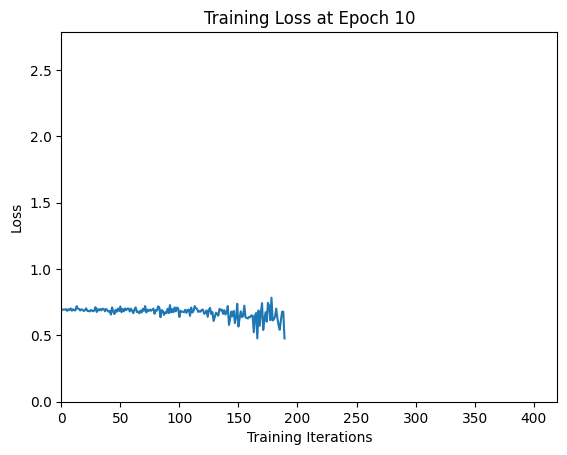

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


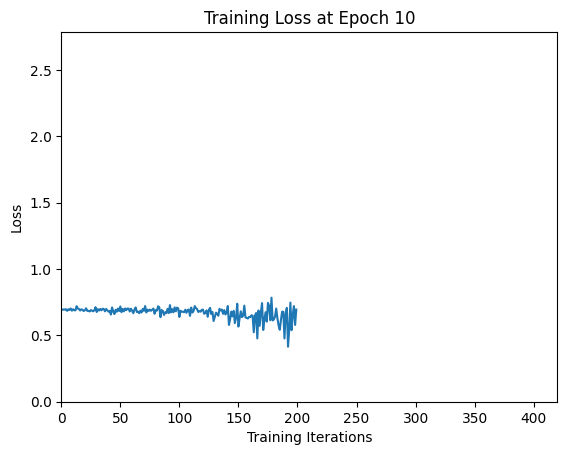

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


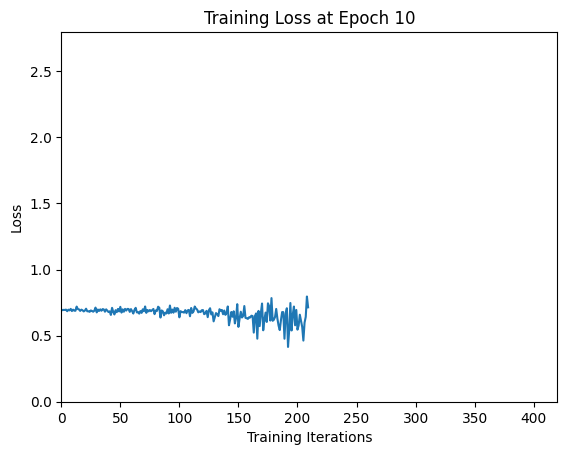

Average Loss after Epoch 10: 0.6147059996922811

Epoch 10, Train Loss: 0.6147059996922811
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 10, Validation Loss: 0.6723788167749133, Validation Accuracy: 0.60
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP022_ANALYSIS/SP022_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP019_ANALYSIS/SP019_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP026_ANALYSIS/SP026_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP006_ANALYSIS/SP006_3.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP001_ANALYSIS/SP001_5.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_

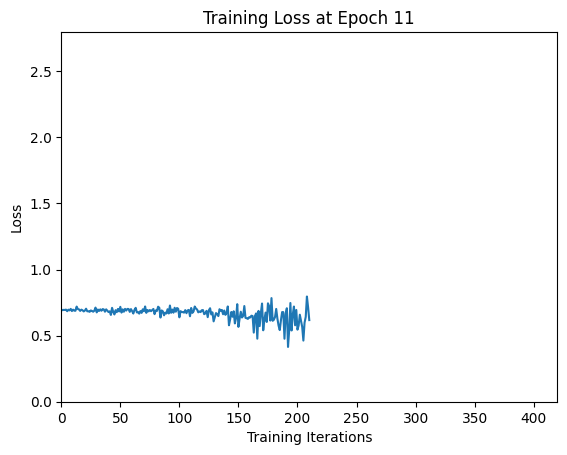

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


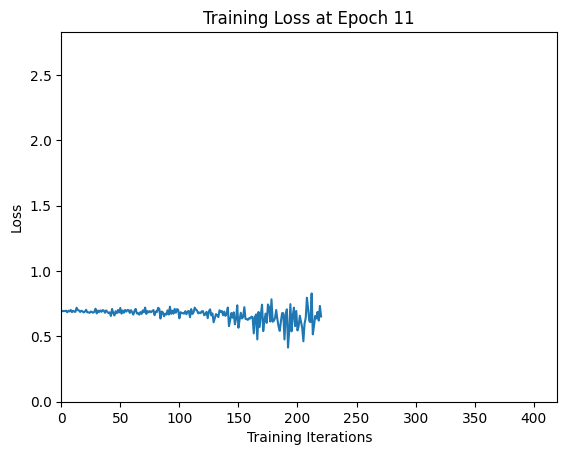

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


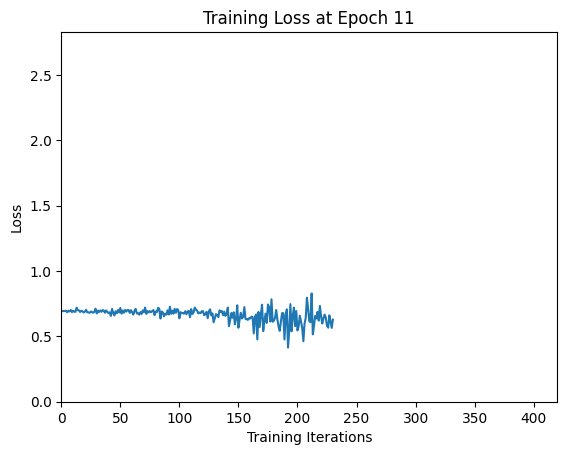

Average Loss after Epoch 11: 0.6335675091970534

Epoch 11, Train Loss: 0.6335675091970534
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 11, Validation Loss: 0.6120990940502712, Validation Accuracy: 0.65
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP022_ANALYSIS/SP022_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP019_ANALYSIS/SP019_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP026_ANALYSIS/SP026_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP001_ANALYSIS/SP001_5.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_

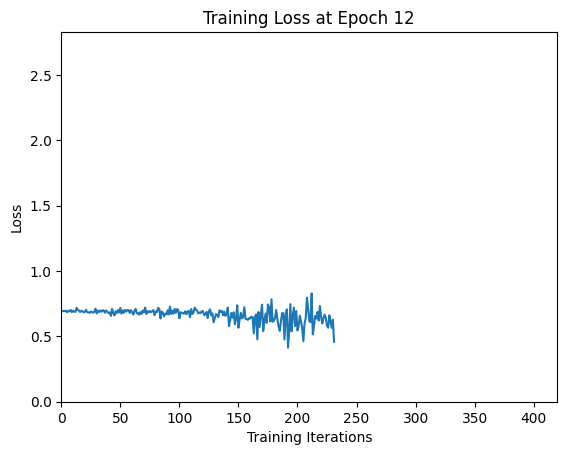

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


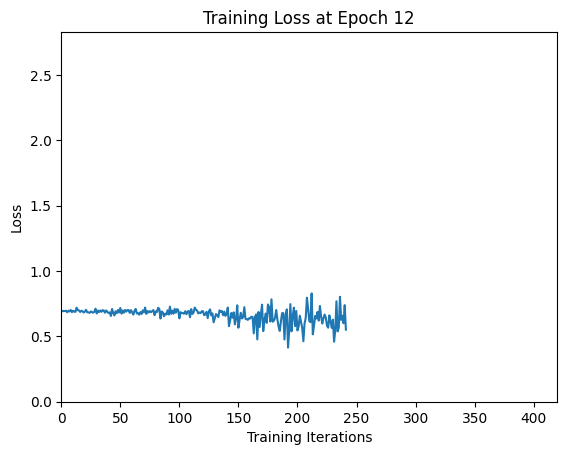

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


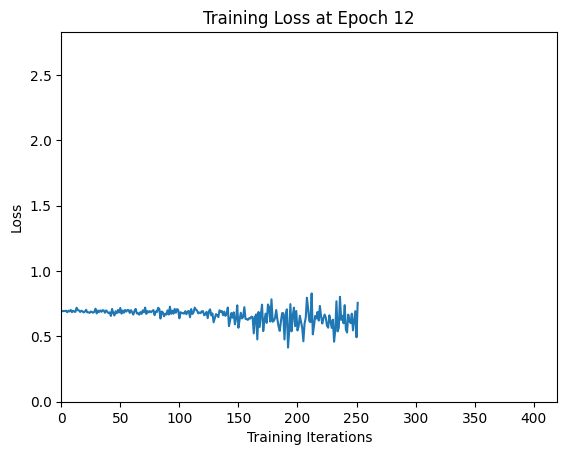

Average Loss after Epoch 12: 0.621954029514676

Epoch 12, Train Loss: 0.621954029514676
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 12, Validation Loss: 0.647880094391959, Validation Accuracy: 0.62
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT011_ANALYSIS/CT011_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP019_ANALYSIS/SP019_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANA

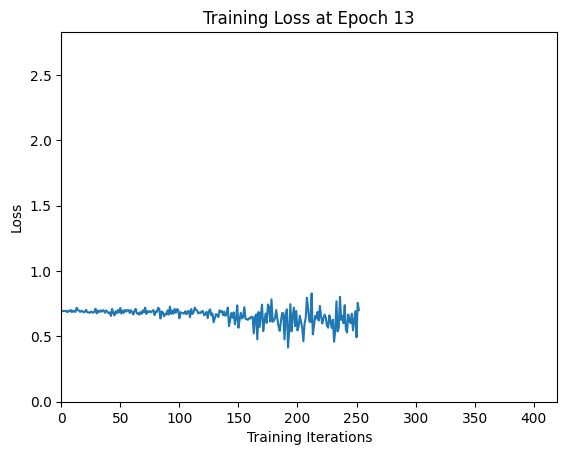

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


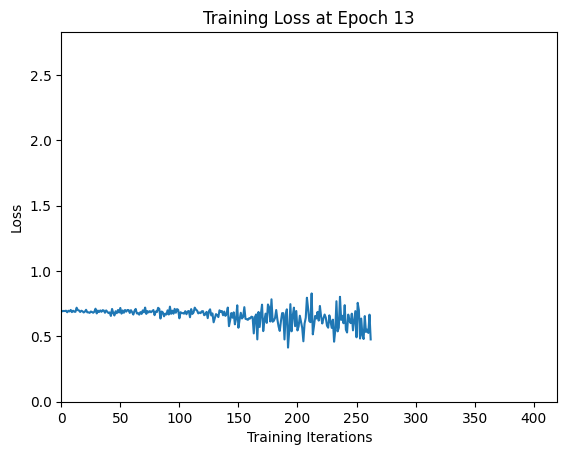

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


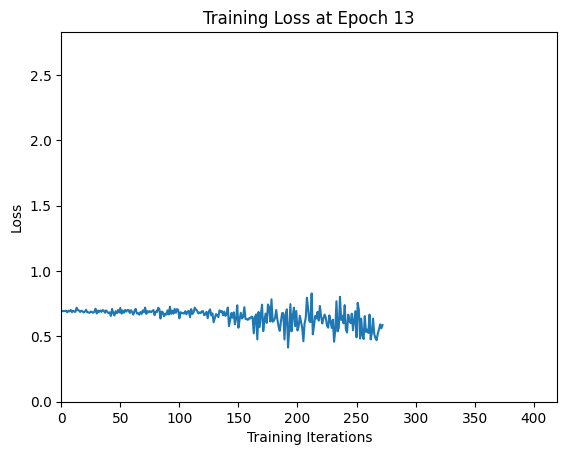

Average Loss after Epoch 13: 0.5558363057318187

Epoch 13, Train Loss: 0.5558363057318187
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 13, Validation Loss: 0.5196061176913125, Validation Accuracy: 0.75
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT011_ANALYSIS/CT011_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP001_ANALYSIS/SP001_5.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP026_ANALYSIS/SP026_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_

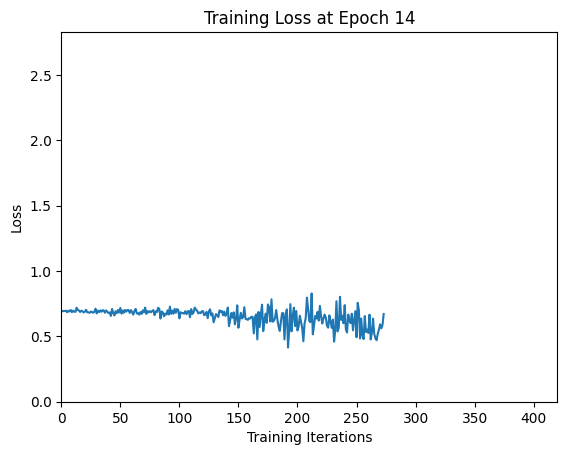

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


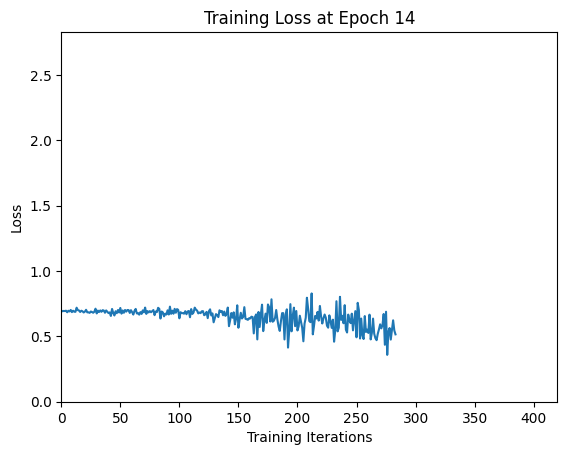

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


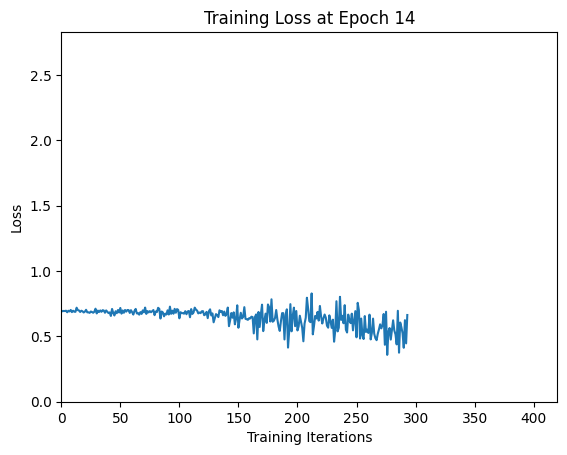

Average Loss after Epoch 14: 0.539138274533408

Epoch 14, Train Loss: 0.539138274533408
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 14, Validation Loss: 0.5767118292195457, Validation Accuracy: 0.67
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP026_ANALYSIS/SP026_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT011_ANALYSIS/CT011_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP019_ANALYSIS/SP019_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_AN

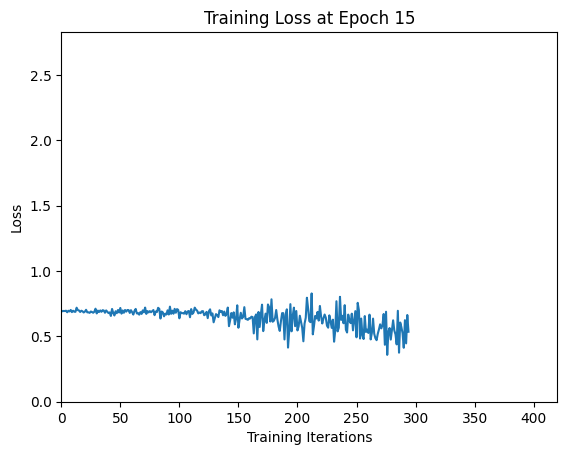

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


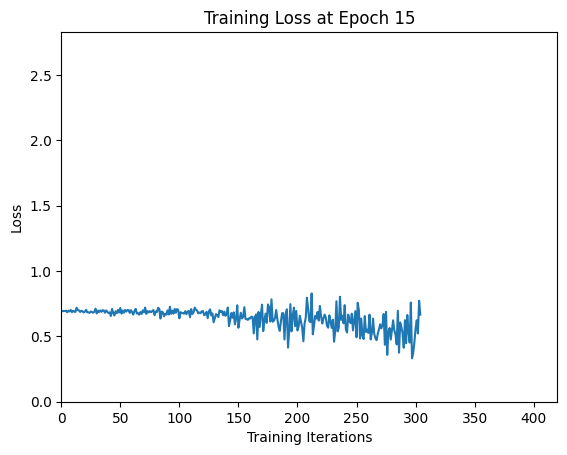

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


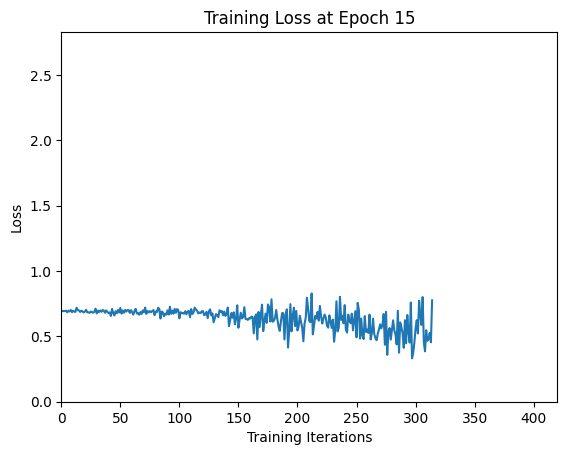

Average Loss after Epoch 15: 0.5491187898885637

Epoch 15, Train Loss: 0.5491187898885637
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 15, Validation Loss: 0.6139638551643917, Validation Accuracy: 0.66
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP019_ANALYSIS/SP019_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_

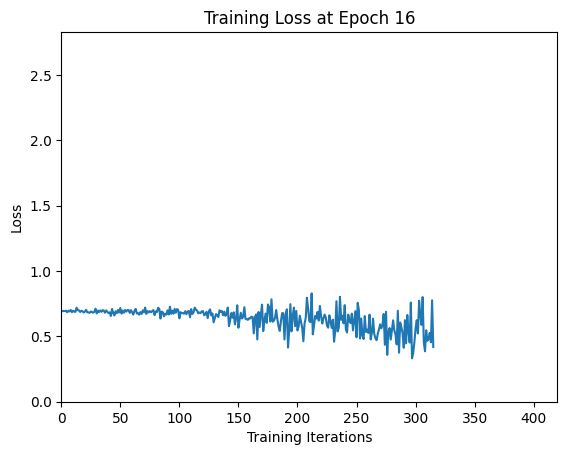

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


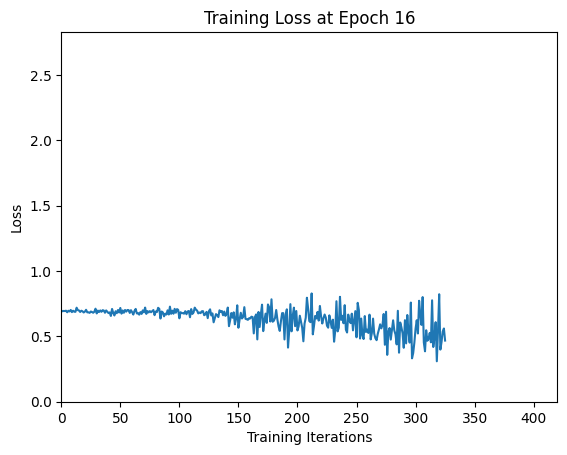

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


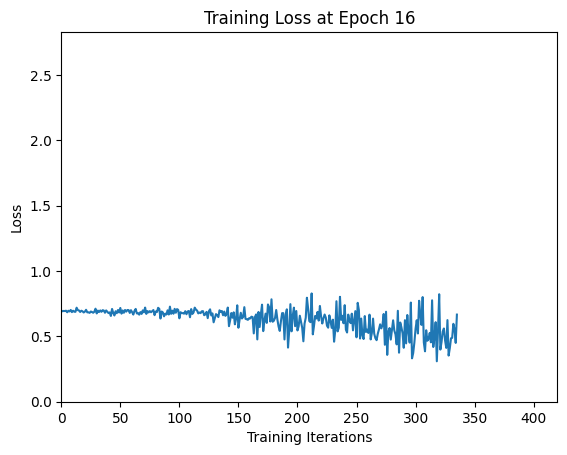

Average Loss after Epoch 16: 0.5078171775454566

Epoch 16, Train Loss: 0.5078171775454566
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 16, Validation Loss: 0.6013040244579315, Validation Accuracy: 0.67
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT011_ANALYSIS/CT011_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP019_ANALYSIS/SP019_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_

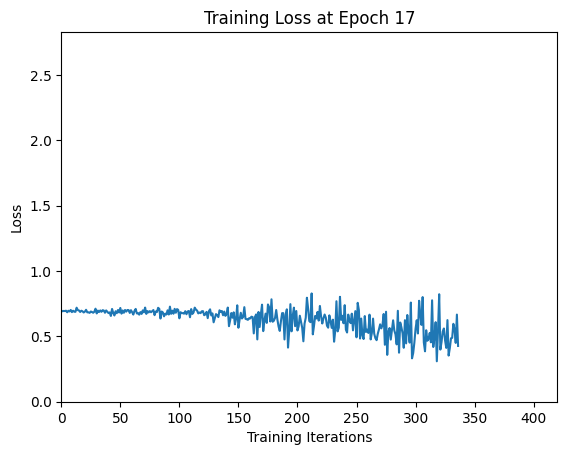

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


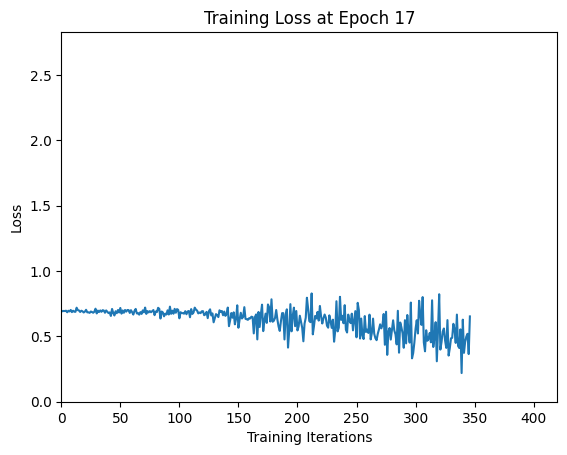

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


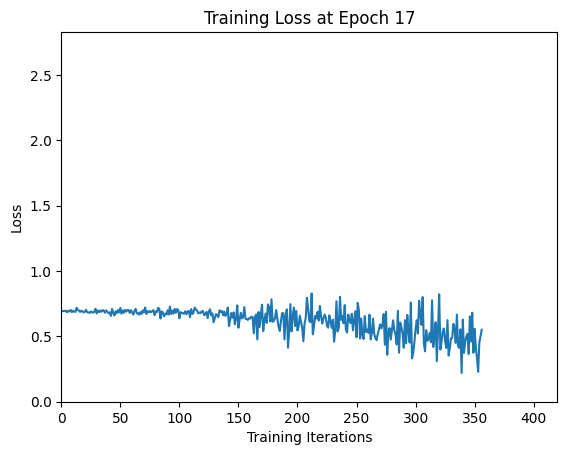

Average Loss after Epoch 17: 0.4605583328576315

Epoch 17, Train Loss: 0.4605583328576315
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 17, Validation Loss: 0.5138603023120335, Validation Accuracy: 0.74
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP026_ANALYSIS/SP026_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP015_ANALYSIS/SP015_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_

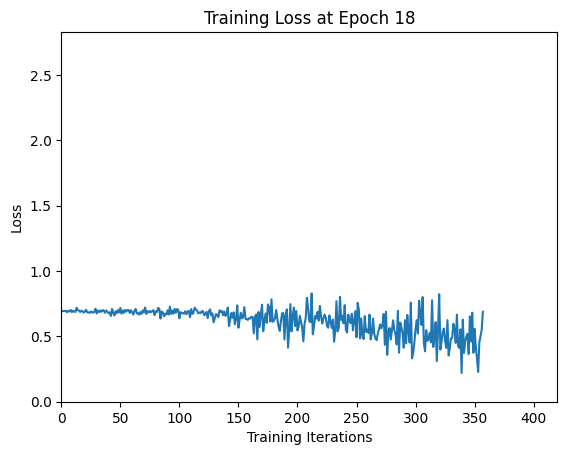

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


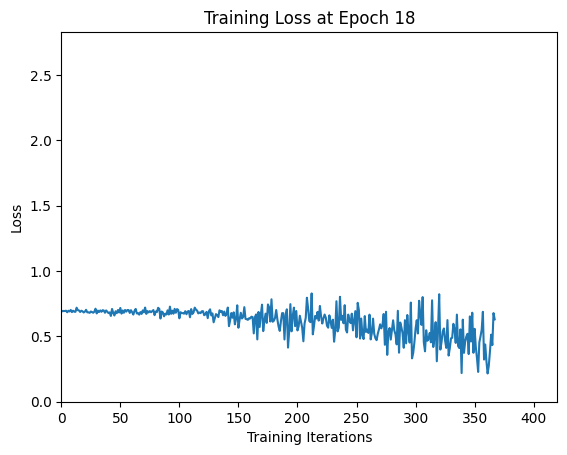

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


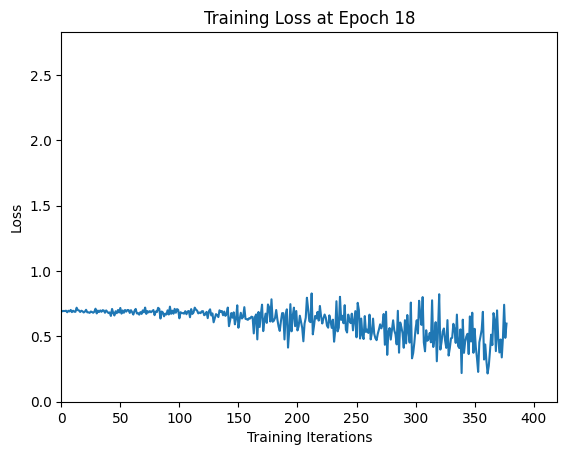

Average Loss after Epoch 18: 0.47518707386084963

Epoch 18, Train Loss: 0.47518707386084963
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 18, Validation Loss: 0.6265196119035993, Validation Accuracy: 0.70
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT004_ANALYSIS/CT004_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT011_ANALYSIS/CT011_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP001_ANALYSIS/SP001_5.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP026_ANALYSIS/SP026_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/S

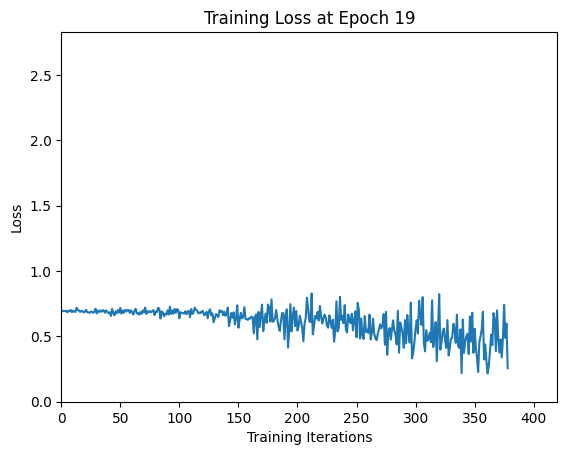

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


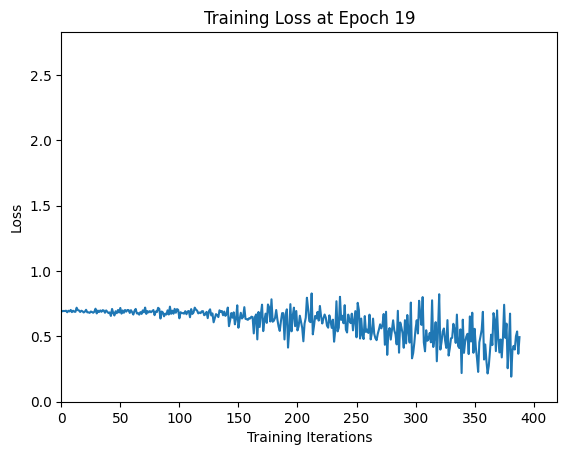

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


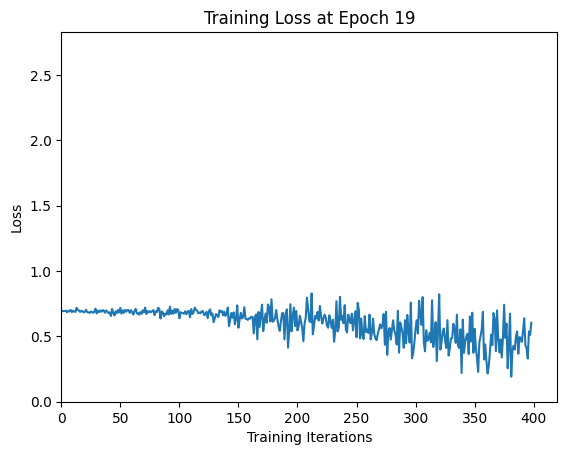

Average Loss after Epoch 19: 0.45826042124203276

Epoch 19, Train Loss: 0.45826042124203276
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 19, Validation Loss: 0.5285829135349819, Validation Accuracy: 0.73
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP014_ANALYSIS/SP014_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP026_ANALYSIS/SP026_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP022_ANALYSIS/SP022_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP015_ANALYSIS/SP015_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP028_ANALYSIS/SP028_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/C

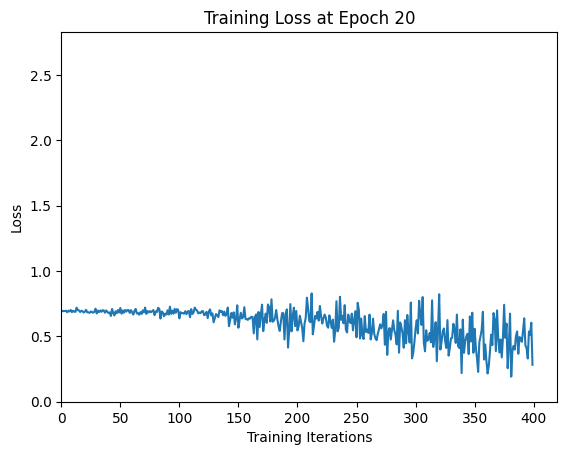

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...


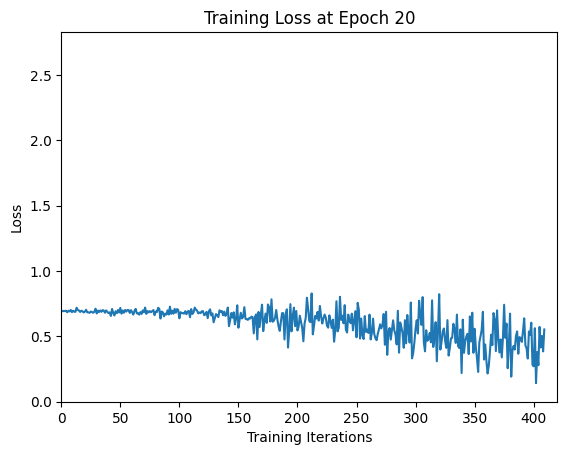

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT026_ANALYSIS/CT026_1.wav. Skipping...


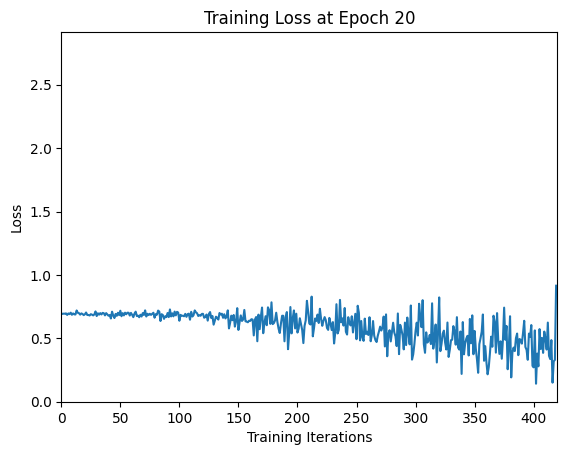

Average Loss after Epoch 20: 0.4180734505256017

Epoch 20, Train Loss: 0.4180734505256017
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 20, Validation Loss: 0.5372796654701233, Validation Accuracy: 0.75
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT011_ANALYSIS/CT011_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP026_ANALYSIS/SP026_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP015_ANALYSIS/SP015_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT027_ANALYSIS/CT027_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_

In [ ]:
epochs = 20
plt.ion()
fig, ax = plt.subplots()
x_vals = np.arange(len(train_loader)*epochs)
loss_vals = []
for epoch in range(epochs):
    train_loss = trainaug(model, train_loader, criterion, optimizer, device, loss_vals, epochs, epoch)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss}")

    val_loss, val_accuracy, wrong_files, true_labels, pred_labels = evaluate(model, validation_loader, criterion, device)
    print(f"Epoch {epoch + 1}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy:.2f}")
    print("Misclassified Files")
    for file_path in wrong_files:
      print(file_path)


    sentence_pattern = re.compile(r"_(\d+)\.wav$")

    sentence_counts = Counter()
    for file_path in wrong_files:
        match = sentence_pattern.search(file_path)
        if match:
            sentence_number = int(match.group(1))
            sentence_counts[sentence_number] += 1

    total_wrong = len(wrong_files)
    print("Total wrong files:", total_wrong)
    print()

    for sentence_number, count in sentence_counts.most_common():
        percent = count / total_wrong * 100
        print(f"Sentence {sentence_number}: {count} ({percent:.2f}%)")
    scheduler.step()
    print(classification_report(true_labels, pred_labels, target_names=['non_dysarthria', 'dysarthria']))
audio_file = "/content/drive/MyDrive/torgo_data/dysarthria_male/validation/M01_Session1_0005.wav"
# predicted_label = predict(model, audio_file, train_dataset.processor, device)
# print(f"Predicted label: {predicted_label}")





# Test on a specific audio file
##audio_file = "/content/drive/MyDrive/torgo_data/dysarthria_male/validation/M01_Session1_0005.wav"
##predicted_label = predict(model, audio_file, train_dataset.processor, device)
##print(f"Predicted label: {predicted_label}")


Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 1, Validation Loss: 0.5372796654701233, Validation Accuracy: 0.75
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT011_ANALYSIS/CT011_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP026_ANALYSIS/SP026_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP015_ANALYSIS/SP015_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT027_ANALYSIS/CT027_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/

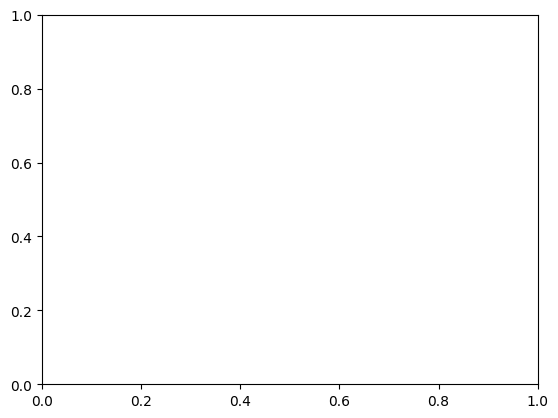

In [ ]:
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Define the pattern to extract the sentence number from the file path
sentence_pattern = re.compile(r"_(\d+)\.wav$")

# Counter for the total number of each sentence type in the dataset
total_sentence_counts = Counter()

for file_path in train_loader.dataset.data: # Access the file paths directly
    match = sentence_pattern.search(file_path)
    if match:
        sentence_number = int(match.group(1))
        total_sentence_counts[sentence_number] += 1

epochs = 1
plt.ion()
fig, ax = plt.subplots()
x_vals = np.arange(len(train_loader)*epochs)
loss_vals = []

for epoch in range(epochs):
    # train_loss = trainaug(model, train_loader, criterion, optimizer, device, loss_vals, epochs, epoch)
    # print(f"Epoch {epoch + 1}, Train Loss: {train_loss}")

    val_loss, val_accuracy, wrong_files, true_labels, pred_labels = evaluate(model, validation_loader, criterion, device)
    print(f"Epoch {epoch + 1}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy:.2f}")
    print("Misclassified Files")
    for file_path in wrong_files:
        print(file_path)

    # Counter for the misclassified sentences
    sentence_counts = Counter()

    for file_path in wrong_files:
        match = sentence_pattern.search(file_path)
        if match:
            sentence_number = int(match.group(1))
            sentence_counts[sentence_number] += 1

    print("Total wrong files:", len(wrong_files))
    print()

    for sentence_number, count in sentence_counts.most_common():
        percent = count / total_sentence_counts[sentence_number] * 100
        print(f"Sentence {sentence_number}: {count} ({percent:.2f}%)")

    scheduler.step()
    print(classification_report(true_labels, pred_labels, target_names=['non_dysarthria', 'dysarthria']))


In [ ]:
torch.save(model.state_dict(), "dysarthria_classifier2.pth")


In [ ]:
save_dir = "models/my_model_06"
model.save_pretrained(save_dir)

## Cross testing


Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...
Epoch 1, Validation Loss: 0.5372796654701233, Validation Accuracy: 0.75
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT011_ANALYSIS/CT011_6.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT032_ANALYSIS/CT032_9.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP026_ANALYSIS/SP026_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP015_ANALYSIS/SP015_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT027_ANALYSIS/CT027_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT009_ANALYSIS/CT009_1.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT029_ANALYSIS/CT029_4.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/

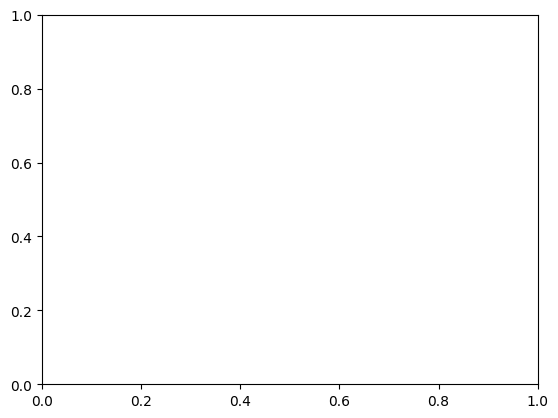

In [ ]:


   # dysarthria_validation_path = "/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/testing"
   # non_dysarthria_validation_path = "/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/testing"

    #dysarthria_validation_files = get_wav_files(dysarthria_validation_path)
   # non_dysarthria_validation_files = get_wav_files(non_dysarthria_validation_path)

    #validation_data = dysarthria_validation_files + non_dysarthria_validation_files
    #validation_labels = [1] * len(dysarthria_validation_files) + [0] * len(non_dysarthria_validation_files)

epochs = 1
plt.ion()
fig, ax = plt.subplots()
x_vals = np.arange(len(train_loader)*epochs)
loss_vals = []
for epoch in range(epochs):
    #train_loss = train(model, train_loader, criterion, optimizer, device, loss_vals, epochs, epoch)
    #print(f"Epoch {epoch + 1}, Train Loss: {train_loss}")

    val_loss, val_accuracy, wrong_files, true_labels, pred_labels = evaluate(model, validation_loader, criterion, device)
    print(f"Epoch {epoch + 1}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy:.2f}")
    print("Misclassified Files")
    for file_path in wrong_files:
      print(file_path)


    sentence_pattern = re.compile(r"_(\d+)\.wav$")

    sentence_counts = Counter()
    for file_path in wrong_files:
        match = sentence_pattern.search(file_path)
        if match:
            sentence_number = int(match.group(1))
            sentence_counts[sentence_number] += 1

    total_wrong = len(wrong_files)
    print("Total wrong files:", total_wrong)
    print()

    for sentence_number, count in sentence_counts.most_common():
        percent = count / total_wrong * 100
        print(f"Sentence {sentence_number}: {count} ({percent:.2f}%)")
    scheduler.step()
    print(classification_report(true_labels, pred_labels, target_names=['non_dysarthria', 'dysarthria']))
audio_file = "/content/drive/MyDrive/torgo_data/dysarthria_male/validation/M01_Session1_0005.wav"
predicted_label = predict(model, audio_file, train_dataset.processor, device)
print(f"Predicted label: {predicted_label}")





# Test on a specific audio file
##audio_file = "/content/drive/MyDrive/torgo_data/dysarthria_male/validation/M01_Session1_0005.wav"
##predicted_label = predict(model, audio_file, train_dataset.processor, device)
##print(f"Predicted label: {predicted_label}")


## DEBUGGING

In [ ]:
dysarthria_path = "/content/drive/MyDrive/torgo_data/dysarthria_male/training"
non_dysarthria_path = "/content/drive/MyDrive/torgo_data/non_dysarthria_male/training"

dysarthria_files = [os.path.join(dysarthria_path, f) for f in os.listdir(dysarthria_path) if f.endswith('.wav')]
non_dysarthria_files = [os.path.join(non_dysarthria_path, f) for f in os.listdir(non_dysarthria_path) if f.endswith('.wav')]

data = dysarthria_files + non_dysarthria_files
labels = [1] * len(dysarthria_files) + [0] * len(non_dysarthria_files)

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

train_dataset = DysarthriaDataset(train_data, train_labels)
test_dataset = DysarthriaDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=4, drop_last=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(device)
# model.classifier = nn.Linear(model.config.hidden_size, 2).to(device)

model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=2).to(device)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForSequenceClassification: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['projector.weight', 'classifier.bias', 'wav2vec2.masked_spec_embed', 'classifier.weight', 'projector.bias']
You should probably TRAIN this model on a down-stream task to be 

In [ ]:
max_length = 100_000
processor = train_dataset.processor

model.eval()
audio_file = "/content/drive/MyDrive/torgo_data/dysarthria_male/validation/M01_Session1_0005.wav"
# predicted_label = predict(model, audio_file, train_dataset.processor, device)
# print(f"Predicted label: {predicted_label}")

wav_data, _ = sf.read(audio_file)
inputs = processor(wav_data, sampling_rate=16000, return_tensors="pt", padding=True)
input_values = inputs.input_values.squeeze(0)  # Squeeze the batch dimension
if max_length - input_values.shape[-1] > 0:
    input_values = torch.cat([input_values, torch.zeros((max_length - input_values.shape[-1],))], dim=-1)
else:
    input_values = input_values[:max_length]

input_values = input_values.unsqueeze(0).to(device)
input_values.shape

torch.Size([1, 100000])

In [ ]:
with torch.no_grad():
  outputs = model(**{"input_values": input_values})
  logits = outputs.logits

In [ ]:
input_values.shape, logits.shape

(torch.Size([1, 100000]), torch.Size([1, 2]))

In [ ]:
import torch.nn.functional as F
# Remove the batch dimension.
logits = logits.squeeze()
predicted_class_id = torch.argmax(logits, dim=-1)
predicted_class_id

tensor(1, device='cuda:0')

Cross testing

##origial code

In [ ]:
import os
import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
from sklearn.model_selection import train_test_split

# Custom Dataset class
class DysarthriaDataset(Dataset):
    def __init__(self, data, labels, max_length=100000):
        self.data = data
        self.labels = labels
        self.max_length = max_length
        self.processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
          wav_data, _ = sf.read(self.data[idx])
        except:
          print(f"Error opening file: {self.data[idx]}. Skipping...")
          return self.__getitem__((idx + 1) % len(self.data))
        inputs = self.processor(wav_data, sampling_rate=16000, return_tensors="pt", padding=True)
        input_values = inputs.input_values.squeeze(0)  # Squeeze the batch dimension
        if self.max_length - input_values.shape[-1] > 0:
            input_values = torch.cat([input_values, torch.zeros((self.max_length - input_values.shape[-1],))], dim=-1)
        else:
            input_values = input_values[:self.max_length]

        # Remove unsqueezing the channel dimension
        # input_values = input_values.unsqueeze(0)

        # label = torch.zeros(32,dtype=torch.long)
        # label[self.labels[idx]] = 1

        ### CHANGES: simply return the label as a single integer
        return {"input_values": input_values}, self.labels[idx]
        ###


def train(model, dataloader, criterion, optimizer, device, ax, loss_vals, x_vals, fig,train_loader,epochs):
    model.train()
    running_loss = 0

    for i, (inputs, labels) in enumerate(dataloader):
        inputs = {key: value.squeeze().to(device) for key, value in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(**inputs).logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        # append loss value to list
        loss_vals.append(loss.item())
        running_loss += loss.item()

        if i:
            # update plot
            ax.clear()
            ax.set_xlim([0, len(train_loader)*epochs])
            ax.set_xlabel('Training Iterations')
            ax.set_ylim([0, max(loss_vals) + 2])
            ax.set_ylabel('Loss')
            ax.plot(x_vals[:len(loss_vals)], loss_vals)
            fig.canvas.draw()
            plt.pause(0.001)

    avg_loss = running_loss / len(dataloader)
    print(avg_loss)
    print("\n")
    return avg_loss



def main():
    dysarthria_path = "/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/training"
    non_dysarthria_path = "/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/training"

    dysarthria_files = get_wav_files(dysarthria_path)
    non_dysarthria_files = get_wav_files(non_dysarthria_path)

    data = dysarthria_files + non_dysarthria_files
    labels = [1] * len(dysarthria_files) + [0] * len(non_dysarthria_files)

    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

    train_dataset = DysarthriaDataset(train_data, train_labels)
    test_dataset = DysarthriaDataset(test_data, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=8, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=8, drop_last=True)
    validation_loader = DataLoader(test_dataset, batch_size=8, drop_last=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(device)
    # model.classifier = nn.Linear(model.config.hidden_size, 2).to(device)

    ### NEW CODES
    # It seems like the classifier layer is excluded from the model's forward method (i.e., model(**inputs)).
    # That's why the number of labels in the output was 32 instead of 2 even when you had already changed the classifier.
    # Instead, huggingface offers the option for loading the Wav2Vec model with an adjustable classifier head on top (by setting num_labels).

    model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=2).to(device)
    ###
    #model_path = "/content/dysarthria_classifier3.pth"
    #if os.path.exists(model_path):
        #print(f"Loading saved model {model_path}")
        #model.load_state_dict(torch.load(model_path))

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
    dysarthria_validation_path = "/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/testing"
    non_dysarthria_validation_path = "/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/testing"

    dysarthria_validation_files = get_wav_files(dysarthria_validation_path)
    non_dysarthria_validation_files = get_wav_files(non_dysarthria_validation_path)

    validation_data = dysarthria_validation_files + non_dysarthria_validation_files
    validation_labels = [1] * len(dysarthria_validation_files) + [0] * len(non_dysarthria_validation_files)

    epochs = 10
    fig, ax = plt.subplots()
    x_vals = np.arange(len(train_loader)*epochs)
    loss_vals = []
    nume = 1
    for epoch in range(epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device, ax, loss_vals, x_vals, fig, train_loader, epoch+1)
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss}")

        val_loss, val_accuracy, wrong_files = evaluate(model, validation_loader, criterion, device)
        print(f"Epoch {epoch + 1}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy:.2f}")
        print("Misclassified Files")
        for file_path in wrong_files:
          print(file_path)


        sentence_pattern = re.compile(r"_(\d+)\.wav$")

        sentence_counts = Counter()
        for file_path in wrong_files:
            match = sentence_pattern.search(file_path)
            if match:
                sentence_number = int(match.group(1))
                sentence_counts[sentence_number] += 1

        total_wrong = len(wrong_files)
        print("Total wrong files:", total_wrong)
        print()

        for sentence_number, count in sentence_counts.most_common():
            percent = count / total_wrong * 100
            print(f"Sentence {sentence_number}: {count} ({percent:.2f}%)")


    torch.save(model.state_dict(), "dysarthria_classifier4.pth")
    print("Predicting...")
    # Test on a specific audio file
    ##audio_file = "/content/drive/MyDrive/torgo_data/dysarthria_male/validation/M01_Session1_0005.wav"
    ##predicted_label = predict(model, audio_file, train_dataset.processor, device)
    ##print(f"Predicted label: {predicted_label}")

def predict(model, file_path, processor, device, max_length=100000): ### CHANGES: added max_length as an argument.
    model.eval()
    with torch.no_grad():
        wav_data, _ = sf.read(file_path)
        inputs = processor(wav_data, sampling_rate=16000, return_tensors="pt", padding=True)
        # inputs = {key: value.squeeze().to(device) for key, value in inputs.items()}

        ### NEW CODES HERE
        input_values = inputs.input_values.squeeze(0)  # Squeeze the batch dimension
        if max_length - input_values.shape[-1] > 0:
            input_values = torch.cat([input_values, torch.zeros((max_length - input_values.shape[-1],))], dim=-1)
        else:
            input_values = input_values[:max_length]
        input_values = input_values.unsqueeze(0).to(device)
        inputs = {"input_values": input_values}
        ###

        logits = model(**inputs).logits
        # _, predicted = torch.max(logits, dim=0)

        ### NEW CODES HERE
        # Remove the batch dimension.
        logits = logits.squeeze()
        predicted_class_id = torch.argmax(logits, dim=-1).item()
        ###

    # return predicted.item()
    return predicted_class_id
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0
    correct_predictions = 0
    total_predictions = 0
    wrong_files = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = {key: value.squeeze().to(device) for key, value in inputs.items()}
            labels = labels.to(device)

            logits = model(**inputs).logits
            loss = criterion(logits, labels)
            running_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            wrong_idx = (predicted != labels).nonzero().squeeze().cpu().numpy()
            if wrong_idx.ndim > 0:
              for idx in wrong_idx:
                  wrong_files.append(dataloader.dataset.data[idx])
            elif wrong_idx.size > 0:
                wrong_files.append(dataloader.dataset.data[wrong_idx])


    avg_loss = running_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy, wrong_files



def get_wav_files(base_path):
    wav_files = []
    for subject_folder in os.listdir(base_path):
        subject_path = os.path.join(base_path, subject_folder)
        if os.path.isdir(subject_path):
            for wav_file in os.listdir(subject_path):
                if wav_file.endswith('.wav'):
                    wav_files.append(os.path.join(subject_path, wav_file))
    return wav_files
if __name__ == "__main__":
    main()


FileNotFoundError: ignored